# Machine Annotation - BERTimbau - Combined Stance/Sentiment


---

For this research project, we will be utilizing the BERTimbau pretrained model. See citation below: \

@inproceedings { \
  souza2020bertimbau, \
  author    = {F{\'a}bio Souza and Rodrigo Nogueira and Roberto Lotufo}, \
  title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese}, \
  booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)}, \
  year      = {2020} \
}


## Set Up
Mount to drive to access files for training the model:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Libraries

Install transformers:


In [2]:
!pip install transformers

Import libraries:

In [3]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, pipeline
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, random_split, Subset, RandomSampler, SequentialSampler, Dataset
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import os
import torch
from torch.optim import AdamW
import seaborn as sns
import random
import gc

Package versions:

In [4]:
print(f"Transformers version: {transformers.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Seaborn version: {sns.__version__}")

Transformers version: 4.42.4
Pandas version: 2.1.4
Numpy version: 1.26.4
PyTorch version: 2.3.1+cu121
Scikit-learn version: 1.3.2
Seaborn version: 0.13.1


### Connect to GPU
Connect to GPU if available:

In [5]:
import torch

# If there's a GPU available:
if torch.cuda.is_available():

    # Use GPU
    device = torch.device("cuda")

    print("There are available GPU(s).") # torch.cuda.device_cour

    print("We will use the GPU:", torch.cuda.get_device_name(0))

# If not

else:
    print("No GPU available, using CPU")
    device = torch.device("cpu")

There are available GPU(s).
We will use the GPU: Tesla T4


## GLOBAL VARIABLES - MODEL

Below are global variables related to training the model. \
This will make the code more maintainable and easier to experiment with new values.

Seed values used: [66, 109, 85, 42, 120, 172, 239, 19, 124, 48, 83, 184, 47, 160, 238, 49, 209, 110, 174, 118]

In [8]:
import os

MODEL_TYPE = 'neuralmind/bert-base-portuguese-cased'
NUM_CLASSES = 9

SEED_VAL = 66

NUM_FOLDS = 5
NUM_EPOCHS = 5

L_RATE = 2e-5 # Testar novos valores
MAX_LEN = 256 # Testar novos valores
BATCH_SIZE = 32 # Testar novos valores
EPS = 1e-8 # Testar novos valores


NUM_CORES = os.cpu_count()

## GLOBAL VARIABLES - DATA
FILE_PATH = path to data file that will be used \

RELEVANCE = name of column representing relevance \
RELEVANCE_ID = column value that represents (relevance == True) \

POST = name of column representing the content of the tweet \
POST_DATE = name of column representing the post date \
POST_ID = name of column representing the tweet id

YEAR = year of when the dataset is from (to be used for file/folder naming)

In [9]:
FILE_PATH = '/content/drive/MyDrive/pesquisa-usp/combined_results_round27_V2-2020.csv'
FOLDER_PATH = ('/content/drive/MyDrive/pesquisa-usp/data_classification_models/stance-sentiment/seed_' + str(SEED_VAL) + '/')

RELEVANCE = 'Corrected_relevante'
RELEVANCE_ID = 'relevant'

SENTIMENT = 'Corrected_sentimento'
POSITIVE_SENTIMENT = 'positive'
NEGATIVE_SENTIMENT = 'negative'

STANCE = 'Corrected_stance'
POSITIVE_STANCE = 'favorable'
NEGATIVE_STANCE = 'unfavorable'

POST = 'content'
POST_DATE = 'post_date'
POST_ID = 'tweet_id'

YEAR = '2020'


## Load BERT

Here, we will load BertForSequenceClassification. \
This is a pre-trained BERT model with a single linear classification layer on top.

In [10]:
from transformers import BertForSequenceClassification


model = BertForSequenceClassification.from_pretrained(
          MODEL_TYPE,
          num_labels = NUM_CLASSES,
          output_attentions = False,
          output_hidden_states = False
        )


# Send the model to the device:
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e



---


We will also save the path to this model so that it can be accessed at the start of the training loop.\
Variation of performance was observed when a new BertForSequenceClassification model is loaded.

We plan to compare pre-training performance with post-training performance. \
Thus, we want to ensure that the model being trained is the same model that was previously evaluated.

In [11]:
model_name = 'original_model.bin'

torch.save(model.state_dict(), model_name)
print('Saved model as', model_name)

Saved model as original_model.bin


## Load Tokenizer

Load BERT tokenizer:

In [12]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE, do_lower_case=False)

Loading BERT tokenizer...


## Prepare Dataset

---

Load the cvs file of the dataset chosen to train the model:

In [13]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

df = pd.read_csv(FILE_PATH)

Filter relevant items:

In [14]:
df = df[df[RELEVANCE] == RELEVANCE_ID]
print(df[RELEVANCE].value_counts())

Corrected_relevante
relevant    1407
Name: count, dtype: int64


Run this cell to display the dataset:

In [15]:
df

,tweet_id,content,Corrected_sentimento,Corrected_stance,Corrected_relevante,Corrected_children,round,date_post,year
0,A522,A cabeça pensa onde o pé pisa. Quem governa de...,negative,favorable,relevant,true,1,2020-09-15,2020
1,A457,Sarto vai fazer um grande Programa de Enfrenta...,positive,favorable,relevant,false,1,2020-11-20,2020
2,A445,A Câmara dos Deputados votou hoje a MP que tra...,negative,favorable,relevant,false,1,2020-12-18,2020
3,A546,Tirar Bolsonaro do poder é uma questão de vida...,negative,favorable,relevant,false,1,2020-11-10,2020
4,A847,E a LIESA decidiu adiar os desfiles do #Carnav...,negative,favorable,relevant,false,1,2020-09-24,2020
...,...,...,...,...,...,...,...,...,...
2981,B1751,A dermatologista Ligia Kogos receitou hidroxic...,negative,unclear,relevant,false,27,2020-04-18,2020
2984,B1907,"Neste sábado, a China injetou sua primeira vac...",positive,favorable,relevant,false,27,2020-03-21,2020
2989,B2077,A fabricação de cloroquina pelas Forças Armada...,negative,unclear,relevant,false,27,2020-05-20,2020
2992,B2122,Enquanto o Brasil recebe cloroquina do EUA e a...,negative,unclear,relevant,false,27,2020-06-17,2020


###  Parsing

Here, we will recode the class names to use integers instead of strings:

In [16]:
classes = {0:'unfav/neg',
           1:'unfav/pos',
           2:'unfav/unclear',
           3:'fav/neg',
           4:'fav/pos',
           5:'fav/unclear',
           6:'unclear/neg',
           7:'unclear/pos',
           8:'unclear/unclear'}

In [17]:
def condition(stance, sentiment):
    if stance == NEGATIVE_STANCE:
        if sentiment == NEGATIVE_SENTIMENT:
          return 0
        elif sentiment == POSITIVE_SENTIMENT:
          return 1
        else: # unclear sentiment
          return 2

    elif stance == POSITIVE_STANCE:
        if sentiment == NEGATIVE_SENTIMENT:
          return 3
        elif sentiment == POSITIVE_SENTIMENT:
          return 4
        else: # unclear sentiment
          return 5

    else: # unclear stance
        if sentiment == NEGATIVE_SENTIMENT:
          return 6
        elif sentiment == POSITIVE_SENTIMENT:
          return 7
        else: # unclear sentiment
          return 8

In [18]:
df['CLASS'] = df.apply(lambda row: condition(row[STANCE], row[SENTIMENT]), axis=1)
df[[STANCE, SENTIMENT, 'CLASS']]

,Corrected_stance,Corrected_sentimento,CLASS
0,favorable,negative,3
1,favorable,positive,4
2,favorable,negative,3
3,favorable,negative,3
4,favorable,negative,3
...,...,...,...
2981,unclear,negative,6
2984,favorable,positive,4
2989,unclear,negative,6
2992,unclear,negative,6


We will illustrate this recoding of class names by displaying the class distributions again:

In [19]:
print(df['CLASS'].value_counts())

CLASS
3    539
4    355
6    265
0     84
7     80
8     38
5     31
1      8
2      7
Name: count, dtype: int64


Plot overall class distribution and save the graph as a png:

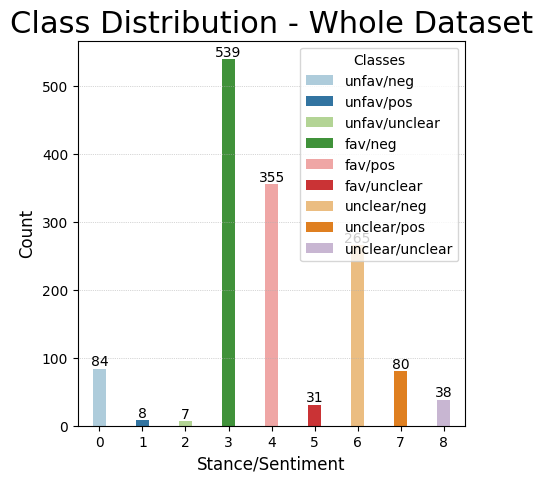

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
ax = sns.countplot(df,
                   x='CLASS',
                   hue='CLASS',
                   palette="Paired",
                   width=0.3,
                   legend=False
                  )

plt.title("Class Distribution - Whole Dataset",fontsize=22)
plt.xlabel('Stance/Sentiment',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(title='Classes', labels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]])

# plt.xticks([0,1,2,3,4,5,6,7,8],[classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8], classes[9]])

plt.grid(True,axis='y',
         linestyle=':',
         linewidth=0.5
        )

for i in ax.containers:
    ax.bar_label(i,)


plt.savefig(FOLDER_PATH+'CombinedClassDistribution_WholeDataset_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )

### Split Train/Test Sets

Here, we separate **20%** of the total observations for the **test set**. \\
We use train_test_split so that the **data is shuffled** before splitting, using a seed (SEED_VAL) for the random state. \\
We use a stratifier to ensure that **class distribution proportions are maintained** in both sets. \\

**NOTE:** Train and Test sets should be tokenized and processed separately to avoid data leakage. \\

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df,
                                     test_size = 0.2, # 20% for the test set
                                     stratify = df['CLASS'], # maintain class proportions
                                     random_state = SEED_VAL # ensures reproducibility of results
                                    )

Display class distributions of each set:

In [23]:
print("Training Set Class Distribution:")
print(df_train['CLASS'].value_counts())
print("\nTest Set Class Distribution:")
print(df_test['CLASS'].value_counts())

Training Set Class Distribution:
CLASS
3    431
4    284
6    212
0     67
7     64
8     30
5     25
1      6
2      6
Name: count, dtype: int64

Test Set Class Distribution:
CLASS
3    108
4     71
6     53
0     17
7     16
8      8
5      6
1      2
2      1
Name: count, dtype: int64


Here, we plot class distributions across training/test sets and save graph as a png. \
We add the DATASET column for plotting purposes, it will not be relevant later.

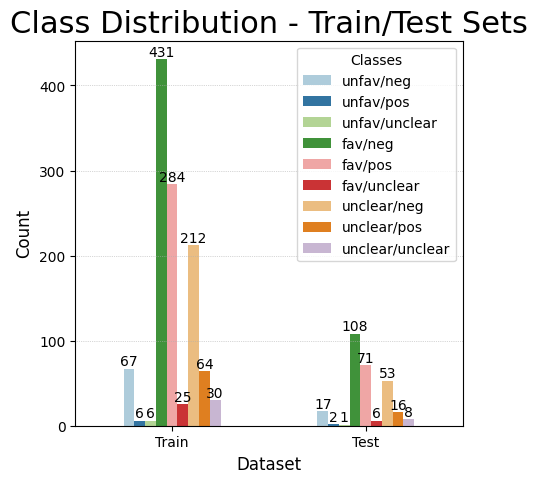

In [26]:
df_train['DATASET'] = 'Train'
df_test['DATASET'] = 'Test'

# Combine the two DataFrames
df_combined = pd.concat([df_train, df_test])

# Plot class distributions in a single plot
plt.figure(figsize=(5, 5))
ax = sns.countplot(x='DATASET',
                   hue='CLASS',
                   data=df_combined,
                   palette="Paired",
                   width=0.5
                  )

plt.title('Class Distribution - Train/Test Sets', fontsize=22)
plt.xlabel('Dataset',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.legend(title='Classes', labels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]])

plt.grid(True,axis='y',
         linestyle=':',
         linewidth=0.5
        )

for i in ax.containers:
    ax.bar_label(i,)

plt.savefig(FOLDER_PATH+'CombinedClassDistribution_TrainTestSplit_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )

### Custom Dataset Class

This class will be used to tokenize sentences:

In [27]:
from torch.utils.data import Dataset

class TweetDataset(Dataset):
  def __init__(self, df):
    self.df_data = df

  def __getitem__(self, index):
    # Get the sentences from the dataframe
    sentence = self.df_data.iloc[index][POST]

    # Transform the sentence

    encoded_dict = tokenizer.encode_plus(sentence,  # Sentences to be tokenized
                                         add_special_tokens = True, # [CLS] and [SEP]
                                         padding = 'max_length',
                                         max_length = MAX_LEN,
                                         return_attention_mask = True, # Build attn. masks.
                                         return_tensors = 'pt', # Return pytorch tensors
                                        )


    # Torch Tensors

    padded_token_list = encoded_dict['input_ids'][0]
    att_mask = encoded_dict['attention_mask'][0]
    token_type_ids = encoded_dict['token_type_ids'][0]


    # Transforming the Target into a tensor

    target = torch.tensor(self.df_data.iloc[index]['CLASS'])

    sample = (padded_token_list, att_mask, token_type_ids, target)

    return sample


  def __len__(self):

    return len(self.df_data)

### Create Test Dataloader

Here, we create an object of the TweetDataset to tokenize all sentences in our curated dataset. \
We then create a DataLoader object to split the test data into batches, which will be used for the testing loop later one.

In [28]:
from torch.utils.data import DataLoader

df_test.reset_index(drop=True, inplace=True)
test_data = TweetDataset(df_test)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_CORES
                            )

print('Test Dataloader Length:',len(test_dataloader))
print('\nIndex Range of Test Dataloader:', df_test.index)
print('\nFirst 5 Rows of Test Dataloader:')
print(df_test.head())


Test Dataloader Length: 9

Index Range of Test Dataloader: RangeIndex(start=0, stop=282, step=1)

First 5 Rows of Test Dataloader:
  tweet_id                                            content  \
0     A743  Vamos preparar POA para receber a vacina contr...   
1     A599  Enquanto isso, a Pfizer desistiu de pedir lice...   
2     A930  Do total, R$ 1,3 bilhão corresponderá à encome...   
3     A589  Idosos com Covid-19 foram isolados em uma sala...   
4     A779  FDA libera vacina da Moderna nos USA enquanto ...   

  Corrected_sentimento Corrected_stance Corrected_relevante  \
0             positive        favorable            relevant   
1             negative        favorable            relevant   
2             positive        favorable            relevant   
3             negative        favorable            relevant   
4             negative          unclear            relevant   

  Corrected_children  round   date_post  year  CLASS DATASET  
0              false     27  2020-10

## Metrics Function

To return evaluation scores, we will use the **classification_report_with_accuracy_score** as defined below.

Arguments: \
- **preds** = a flat list of the predictions of the model as integers
- **labels** = a flat list of the true classification of the corresponding predictions

Returns: \
- **df_class_report** = a DataFrame of the classification report made using **preds** and **labels**, which includes:

 - *precision*, *recall*, and *F1-score* for each class.

 - *macro average* and *weighted average* between both classes for precision, recall and F1-score.


 - **overall_accuracy** = overall *accuracy* of the model.

 All metrics are rounded to the closest 2 decimals.

In [29]:
from sklearn.metrics import classification_report

def classification_report_with_accuracy_score(preds, labels):
    report = classification_report(labels, preds, output_dict = True, zero_division = 0)

    df_class_report = pd.DataFrame(report).transpose()
    df_class_report = df_class_report.round(decimals=2) # for better readibility

    overall_accuracy = np.sum(preds == labels) / len(labels)
    rounded_accuracy = overall_accuracy.round(decimals=2)

    return df_class_report, rounded_accuracy

## Evaluate the BERTimbau Pre-Trained Model



Here, we will evaluate how BERTimbau (a pre-trained model) performs before being trained on our curated dataset. \
We refer to the process of specifically training BERTimbau on our dataset as fine-tuning, which will be done later on.  

\\
We will evaluate performance using the following metrics: \\
- **Accuracy**: correct predictions/total number of instances
- **Precision**: percentage of instances that the model classified correctly for a given class
- **Recall**: percentage of instances of a given class that were classified correctly
- **F1-Score**: harmonic mean of precision and recall
- **Confusion Matrix**: represents number of actual outputs versus predicted outputs


###Test batches

Use the test_dataloader to evaluate BERTimbau's performance, testing in batches:

In [30]:
model.eval()
torch.set_grad_enabled(False)

for i, test_batch in enumerate(test_dataloader):
  test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
  print(test_status, end='\r')

  b_input_ids = test_batch[0].to(device)
  b_input_mask = test_batch[1].to(device)
  b_token_type_ids = test_batch[2].to(device)


  outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  return_dict = False)

  preds = outputs[0]
  test_preds = preds.detach().cpu().numpy()


  if i == 0:  # first batch
    stacked_test_preds = test_preds

  else:
    stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Each prediction returned by the model is a tuple - the logits are still raw.

The first value of the tuple represents the score given for Class 0, and the second value represents the score given for Class 1. \\
To get the real prediction, we take the max of both values to know whether the model's final prediction was Class 0 or Class 1. \\

For clarity, we will illustrate this below:

In [31]:
print("First 5 predictions as a raw logit tuple:\n", stacked_test_preds[0:6])
final_preds = np.argmax(stacked_test_preds, axis=1)
print("\nFirst 5 predictions final decisions after taking the max:\n", final_preds[0:6])


First 5 predictions as a raw logit tuple:
 [[ 0.2859134   0.10252106  0.39325106 -0.12154167  0.05593249  0.2800075
   0.03217018  0.07887799  0.4663385 ]
 [ 0.34628806 -0.011739    0.42716584 -0.10112356  0.02917138  0.3692454
  -0.08491987 -0.02298171  0.43765014]
 [ 0.40066412 -0.03260132  0.34329143 -0.10593966 -0.05328616  0.3127436
  -0.07168449  0.03148011  0.32662085]
 [ 0.32575193  0.03943739  0.33426362 -0.09997442  0.01058464  0.37597615
  -0.04120314  0.06437854  0.3826491 ]
 [ 0.15423912 -0.13619722 -0.02661353  0.00269554 -0.10421629 -0.12738615
   0.00447461  0.22779952 -0.05616163]
 [ 0.33581012 -0.01077135  0.35074717 -0.07745788  0.02024212  0.35674155
  -0.05961171  0.0006549   0.38017407]]

First 5 predictions final decisions after taking the max:
 [8 8 0 8 7 8]


###Performance Scores

Now, we can calculate the model's performance scores using the function that was previously defined. \

It must be noted that when reloading the model and rerunning the tests, a small fluctuation of values was observed in the performance scores. \
It was ensured that the Train/Test split of the dataset and the tokenization of the test set were the same in all trials.


In [32]:
labels = df_test['CLASS']

report, accuracy = classification_report_with_accuracy_score(final_preds, labels)

print(report)

              precision  recall  f1-score  support
0                  0.04    0.06      0.05    17.00
1                  0.00    0.00      0.00     2.00
2                  0.01    1.00      0.02     1.00
3                  0.00    0.00      0.00   108.00
4                  0.00    0.00      0.00    71.00
5                  0.06    0.33      0.11     6.00
6                  0.00    0.00      0.00    53.00
7                  0.00    0.00      0.00    16.00
8                  0.01    0.12      0.02     8.00
accuracy           0.02    0.02      0.02     0.02
macro avg          0.01    0.17      0.02   282.00
weighted avg       0.00    0.02      0.01   282.00


Plot report as a table and save figure as a png:

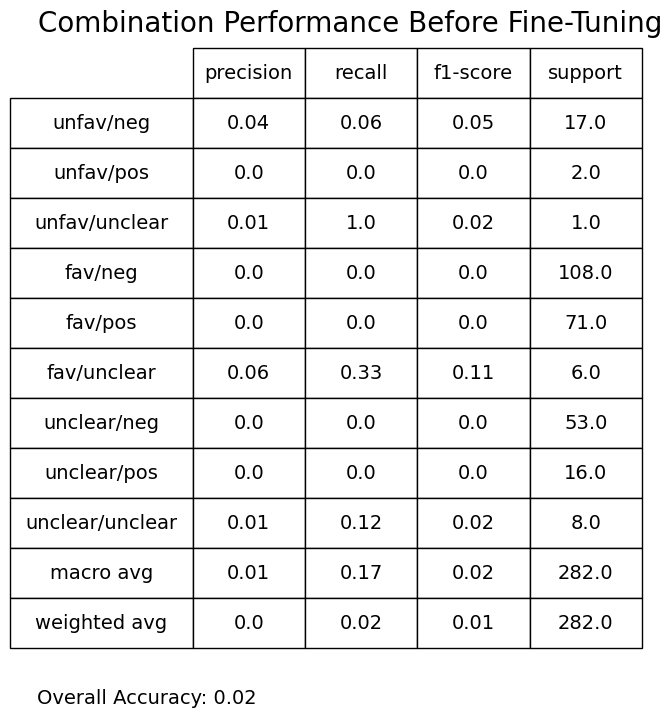

In [34]:
without_acc = report.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', 'macro avg', 'weighted avg']]
without_acc = without_acc.rename(index={'0': classes[0],
                                        '1': classes[1],
                                        '2': classes[2],
                                        '3': classes[3],
                                        '4': classes[4],
                                        '5': classes[5],
                                        '6': classes[6],
                                        '7': classes[7],
                                        '8': classes[8]})

fig, ax = plt.subplots(figsize=(2,8))
ax.axis('off')
table = pd.plotting.table(ax,
                          without_acc,
                          loc='right',
                          cellLoc='center',
                          rowLoc='center'
                         )

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.9, 3)
plt.title('Combination Performance Before Fine-Tuning',
          loc='left',
          fontsize=20
         )

acc_str = 'Overall Accuracy: '+ str(accuracy)
fig.text(0.67, 0.05,
         acc_str,
         ha='center',
         fontsize=14
        )


plt.savefig(FOLDER_PATH+'CombinationPerformanceTable_PreTrainedModel_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )

Plot the confusion matrix to visualize the model's predictions against their true value, and save the figure as a png:

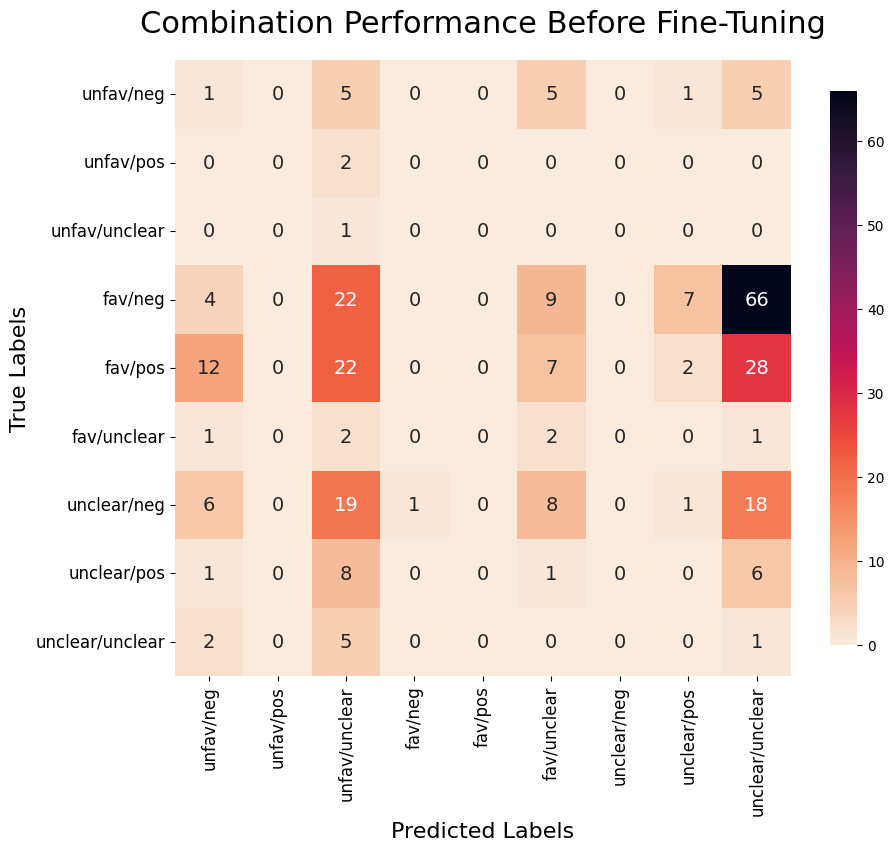

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


matrix = confusion_matrix(df_test['CLASS'], final_preds)

fig = plt.figure(figsize=(10, 8))

ax = sns.heatmap(matrix,
                 annot=True,
                 cmap="rocket_r",
                 fmt = '.0f',
                 yticklabels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]],
                 xticklabels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]],
                 square=True,
                 annot_kws={"size": 14},
                 cbar=True,
                 cbar_kws={'shrink': 0.9}
                )

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add title and labels
plt.title('Combination Performance Before Fine-Tuning',
          fontsize = 22,
          loc = 'center',
          pad = 20
         )

plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.savefig(FOLDER_PATH+'CombinationConfusionMatrix_PreTrainedModel_Seed'+ str(SEED_VAL) + '.png',
            format='png',
            transparent = True,
            bbox_inches='tight',
            pad_inches=0.1
           )


##Train Model

We will now train BERTimbau on our curated dataset.\
The goal is to achieve significantly better evaluation scores compared to the pre-trained model's performance.

###Set the Seed

The seed will ensure reproducibility of these experiments:

In [38]:
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)

###Remove Warnings

In [39]:
from transformers import AdamW
import random
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

# Remove Warnings

from transformers import logging

logging.set_verbosity_warning()

###Create Folds

In order to train the model, we must split the training dataset into train/validation sets.\
To do this, we will create folds such that each fold will have a different randomized (but seed controlled) dataset split.

In [40]:
skf = StratifiedKFold(n_splits = NUM_FOLDS,
                      shuffle = True,
                      random_state = SEED_VAL)

targets = df_train['CLASS']

folds_list = skf.split(df_train,targets)

###Class Distribution Across Folds

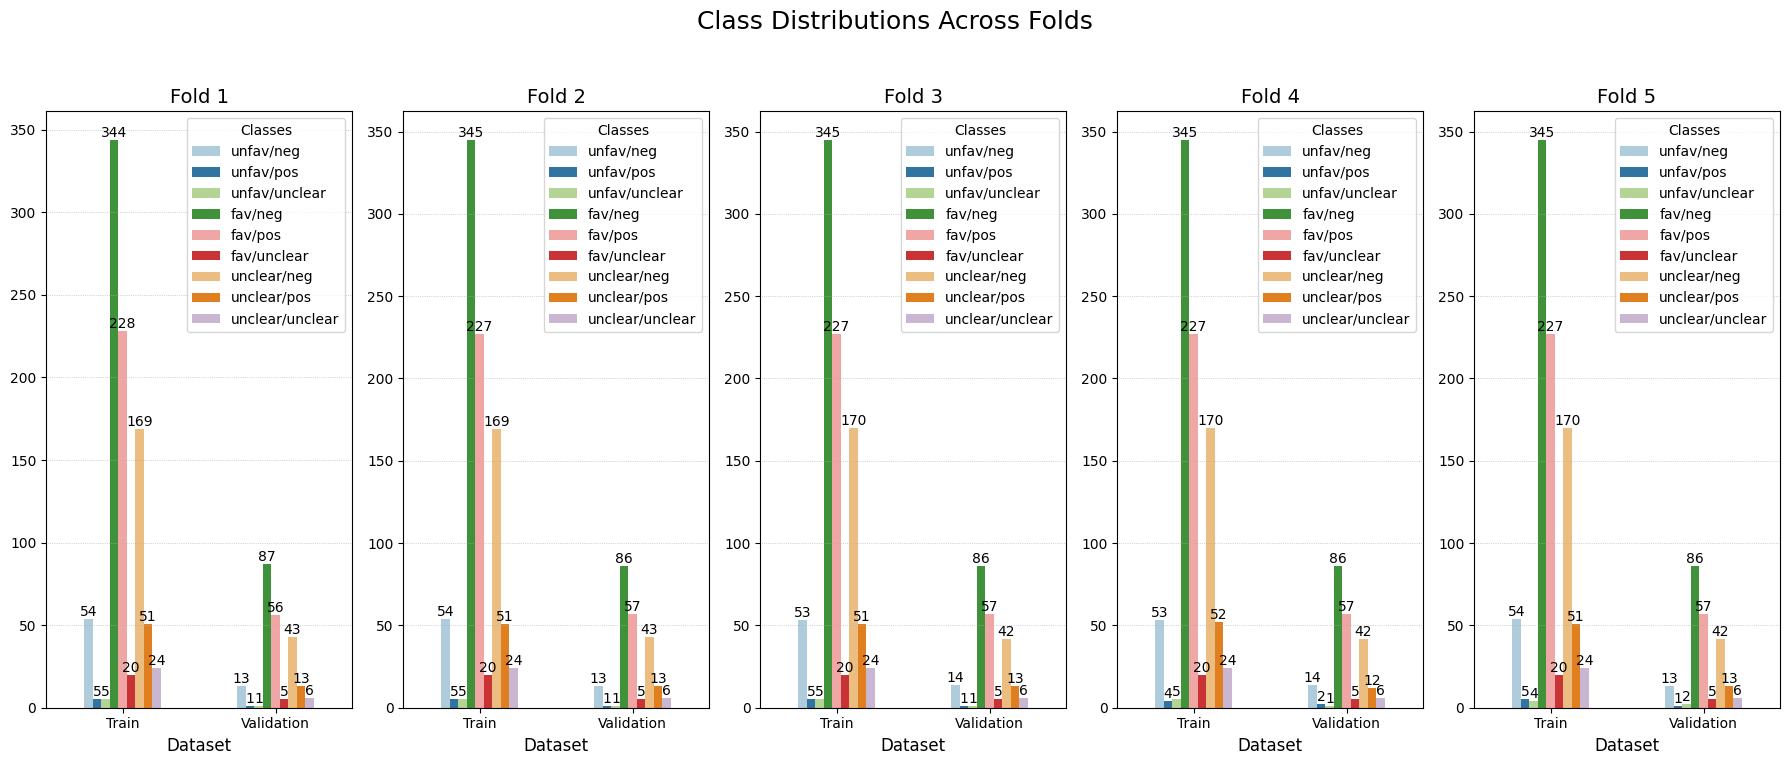

In [41]:
# create a figure with subplots
fig, axes = plt.subplots(1,NUM_FOLDS, figsize=(18, 8))
fig.suptitle('Class Distributions Across Folds', fontsize=18)


for n, (train_index, val_index) in enumerate(skf.split(df_train,targets)):
  train = df_train.iloc[train_index,:]
  validation = df_train.iloc[val_index,:]

  # Group the datasets to be plotted:
  train.loc[:, 'DATASET'] = 'Train'
  validation.loc[:, 'DATASET'] = 'Validation'
  df_combined = pd.concat([train, validation])

  sub_fig = axes[n]
  ax = sns.countplot(ax=sub_fig, x='DATASET', hue='CLASS', data=df_combined, palette="Paired", width=0.5)

  title = 'Fold ' + str(n+1)
  sub_fig.set_title(title, fontsize=14)

  # Set labels and legend
  sub_fig.set_xlabel('Dataset', fontsize=12)
  sub_fig.set_ylabel('')
  sub_fig.legend(title='Classes', loc='upper right', labels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]])
  sub_fig.grid(True, axis='y', linestyle=':', linewidth=0.5)

  for i in ax.containers:
      ax.bar_label(i,)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(FOLDER_PATH+'CombinedClassDistribution_AcrossFolds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

###Lists for Performance Scores/Data

We will use the list below to store performance scores of all epochs across all folds.

Each epoch is a dictionary containing:
- fold number
- epoch number

- total train loss
- average train loss
- total validation loss
- average validation loss

- classification report
- validation accuracy

In [42]:
training_stats = []

###Training Loop

We train the model in NUM_FOLDS folds, each of which will have NUM_EPOCHS epochs.


Each fold loads a new pre-trained BERTimbau model to fine-tune. \

Each epoch in this fold will train the model on the fold's train set, followed by an evaluation of the model using the fold's validation set. \
\
If its Macro F1-score is better than the other epochs, that model will be saved using: \
  - model_name = 'fold_' + str(fold_index) + '.bin'
  - torch.save(model.state_dict(), model_name)





In [43]:
%%time
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
for fold_index, (train_index, val_index) in enumerate(skf.split(df_train,targets)):
  print('\n################## Fold Model Number', str((fold_index+1)) + ' / ' + str(NUM_FOLDS), '##################')

  # ..................................................
  # Defining Dataloaders of Training and Validation
  # ..................................................

  # Train and Validation Sets
  train = df_train.iloc[train_index,:]
  val = df_train.iloc[val_index,:]


  # Reseting Indices so it will work
  train = train.reset_index(drop = True)
  val = val.reset_index(drop = True)


  # Tokenizing and Transforming Inputs (att masks, labels, etc.)
  train_data = TweetDataset(train)
  val_data = TweetDataset(val)

  # Train/Validation Split for this Fold:
  train_dataloader = torch.utils.data.DataLoader(train_data,
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=False,
                                                 num_workers=NUM_CORES)

  val_dataloader = torch.utils.data.DataLoader(val_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=NUM_CORES)

  # ..................................................
  # List for Epoch Evaluation Metric:
  # ..................................................
  fold_f1_macro_list = []

#------------------------------------------------------------------------------
  for epoch in range(NUM_EPOCHS):
#------------------------------------------------------------------------------

    #......................
    # Loading Fold Model
    #......................

    if epoch == 0:

      # Load model from pre-training evaluation:
      model.load_state_dict(torch.load('original_model.bin'))

      optimizer = AdamW(model.parameters(),
                        lr = L_RATE,
                        eps = EPS
                       )

    else:
      # Load the fold's model:
      path_model = 'fold_' + str(fold_index+1) + '.bin'

      if os.path.exists(path_model):
        model.load_state_dict(torch.load(path_model))

      else:
        print(f"Error: {path_model} does not exist")

        model.to(device)


    # ==========================================================================
    #               Training
    # ==========================================================================
    print('============== Epoch {:} / {:} =============='.format(epoch + 1, NUM_EPOCHS))
    print(" ")
    print('\nTraining...')
    print('')

    # Put the model into train mode:
    model.train()

    # Turn gradient calculations on:
    torch.set_grad_enabled(True)


    # .......................................................
    # Defining Variables to Track This Epoch's Performance
    # .......................................................

    # overall stats:
    epoch_stats = {'fold': fold_index + 1,
                   'epoch': epoch + 1}

    total_macro_f1 = 0
    avg_macro_f1 = 0

    # train stats:
    total_train_loss = 0
    avg_train_loss = 0

    # validation stats:
    total_val_loss = 0
    avg_val_loss = 0

    # ..................
    # Train the Model
    # ..................

    for i, batch in enumerate(train_dataloader):

      train_status = 'Batch ' + str(i+1) + ' of ' + str(len(train_dataloader))

      print(train_status, end='\r')


      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_token_type_ids = batch[2].to(device)
      b_labels = batch[3].to(device)

      model.zero_grad()


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)

      # Calculate loss:
      batch_loss = loss.item()

      total_train_loss += batch_loss


      # Zero the gradients:
      optimizer.zero_grad()

      # Perform a backward pass to calculate the gradients:
      loss.backward()


      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


      # Update Weights:
      optimizer.step()   # for GPU

      # https://pytorch.org/xla/
      #xm.optimizer_step(optimizer, barrier=True)   #for TPU


    # ........................................
    # Update Training Performance Variables
    # ........................................

    avg_train_loss = total_train_loss / len(train_dataloader)

    print('Total Train loss:' ,total_train_loss)
    print('Average Train Loss: ', avg_train_loss)


    # .......................................
    # Add Scores to Epoch Stats Dictionary
    # .......................................

    epoch_stats['total_train_loss'] = total_train_loss
    epoch_stats['avg_train_loss'] = avg_train_loss



    # ==========================================================================
    #               Validation
    # ==========================================================================
    print(" ")
    print('=============================================')
    print('\nValidation...')
    print(' ')

    # Put the model in evaluation mode:
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Lists to accumulate all predictions and their corresponding labels:
    stacked_val_preds = []
    val_targets = []


    # .....................
    # Validate the Model
    # .....................

    for j, val_batch in enumerate(val_dataloader):

      val_status = 'Batch ' + str(j+1) + ' of ' + str(len(val_dataloader))

      print(val_status, end='\r')


      b_input_ids = val_batch[0].to(device)
      b_input_mask = val_batch[1].to(device)
      b_token_type_ids = val_batch[2].to(device)
      b_labels = val_batch[3].to(device)


      loss, logits = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           return_dict = False,
                           labels=b_labels)


      # Calculate loss:
      batch_loss = loss.item()
      total_val_loss += batch_loss


      # Move labels and predictions to the CPU:
      batch_targets = b_labels.to('cpu').numpy()
      batch_preds = logits.detach().cpu().numpy()


      # Append the labels and predictions to their lists:
      val_targets.extend(batch_targets)

      if j == 0:
        stacked_val_preds = batch_preds
      else:
        stacked_val_preds = np.vstack((stacked_val_preds, batch_preds))


      batch_preds = np.argmax(batch_preds, axis = 1)

      total_macro_f1 += f1_score(batch_targets,
                                 batch_preds,
                                 average = 'macro'
                                )
      # usage: sklearn.metrics.f1_score(y_true, y_pred)


    # ..........................................
    # Update Validation Performance Variables
    # ..........................................

    avg_val_loss = total_val_loss / len(val_dataloader)

    avg_macro_f1 = total_macro_f1 / len(val_dataloader)


    print('Total Validation loss:' ,total_val_loss)
    print('Average Validation Loss: ', avg_val_loss)

    print("Macro F1-score: {0:.2f}".format(avg_macro_f1))



    stacked_val_preds = np.argmax(stacked_val_preds, axis=1)

    class_report, val_acc = classification_report_with_accuracy_score(stacked_val_preds, val_targets)


    print('Validation accuracy: ', val_acc)
    print('Classification Report: \n', class_report)



    # .......................................
    # Add Scores to Epoch Stats Dictionary
    # .......................................
    epoch_stats['total_val_loss'] = total_val_loss
    epoch_stats['avg_val_loss'] = avg_val_loss
    epoch_stats['val_accuracy'] = val_acc
    epoch_stats['f1_macro'] = avg_macro_f1
    epoch_stats['report'] = class_report

    # .........................................
    # Add Epoch Stats to Training Stats List
    # .........................................
    training_stats.append(epoch_stats)


    # ......................
    # Save the best model
    # ......................

    if epoch == 0:

      # Save the Model:
      model_name = 'fold_' + str(fold_index+1) + '.bin'
      torch.save(model.state_dict(), model_name)
      print('Saved model as', model_name)

    else:

      stop = total_val_loss > total_train_loss


      if not stop:

        model_name = 'fold_' + str(fold_index+1) + '.bin'
        torch.save(model.state_dict(), model_name)

        print('F1-Macro improved. Saved model as', model_name)

      else:
        # remove overfitted epoch stats:
        training_stats.pop()

        print('Model overfitted at epoch', str(epoch+1) + '. Model was not saved.')
        break


    # Use the garbage collector to save memory:
    gc.collect()



################## Fold Model Number 1 / 5 ##################
============== Epoch 1 / 5 ==============
 

Training...



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 51.61805057525635
Average Train Loss:  1.7799327784571155
 

Validation...
 
Total Validation loss: 13.585538506507874
Average Validation Loss:  1.6981923133134842
Macro F1-score: 0.18
Validation accuracy:  0.49
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.45    1.00      0.62    87.00
4                  0.81    0.38      0.51    56.00
5                  0.00    0.00      0.00     5.00
6                  0.60    0.07      0.12    43.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.49    0.49      0.49     0.49
macro avg          0.21    0.16      0.14   225.00
weighted avg       0.49    0.49      0.39   225.00
Saved model as fold_1.bin
============== Epoch 2 / 5 ==============
 

Training...

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 36.261777341365814
Average Train Loss:  1.2504061152195107
 

Validation...
 
Total Validation loss: 10.715945184230804
Average Validation Loss:  1.3394931480288506
Macro F1-score: 0.34
Validation accuracy:  0.7
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00     13.0
1                  0.00    0.00      0.00      1.0
2                  0.00    0.00      0.00      1.0
3                  0.72    0.90      0.80     87.0
4                  0.69    0.77      0.73     56.0
5                  0.00    0.00      0.00      5.0
6                  0.69    0.86      0.76     43.0
7                  0.00    0.00      0.00     13.0
8                  0.00    0.00      0.00      6.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.23    0.28      0.25    225.0
weighted avg       0.58    0.70      0.63    225.0
F1-Macro improved. Saved model as fold_1.bin
============== Epoch 3 / 5 ==========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 26.11867880821228
Average Train Loss:  0.9006440968349062
 

Validation...
 
Total Validation loss: 9.241083145141602
Average Validation Loss:  1.1551353931427002
Macro F1-score: 0.39
Validation accuracy:  0.71
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.71    0.92      0.80    87.00
4                  0.74    0.70      0.72    56.00
5                  0.00    0.00      0.00     5.00
6                  0.72    0.84      0.77    43.00
7                  0.56    0.38      0.45    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.30    0.32      0.30   225.00
weighted avg       0.63    0.71      0.66   225.00
F1-Macro improved. Saved model as fold_1.bin
============== Epoch 4 / 5 ===========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 19.12368381023407
Average Train Loss:  0.659437372766692
 

Validation...
 
Total Validation loss: 8.314563393592834
Average Validation Loss:  1.0393204241991043
Macro F1-score: 0.44
Validation accuracy:  0.73
Classification Report: 
               precision  recall  f1-score  support
0                  0.50    0.23      0.32    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.79    0.80      0.80    87.00
4                  0.69    0.86      0.76    56.00
5                  0.00    0.00      0.00     5.00
6                  0.75    0.84      0.79    43.00
7                  0.67    0.62      0.64    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.38    0.37      0.37   225.00
weighted avg       0.69    0.73      0.70   225.00
F1-Macro improved. Saved model as fold_1.bin
============== Epoch 5 / 5 ============

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 13.893573962152004
Average Train Loss:  0.47908875731558637
 

Validation...
 
Total Validation loss: 8.573313474655151
Average Validation Loss:  1.071664184331894
Macro F1-score: 0.46
Validation accuracy:  0.76
Classification Report: 
               precision  recall  f1-score  support
0                  0.56    0.38      0.45    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.83    0.82      0.82    87.00
4                  0.69    0.89      0.78    56.00
5                  0.00    0.00      0.00     5.00
6                  0.80    0.84      0.82    43.00
7                  0.62    0.62      0.62    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.39    0.39      0.39   225.00
weighted avg       0.71    0.76      0.73   225.00
F1-Macro improved. Saved model as fold_1.bin

################## Fold Model Number

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 51.9460551738739
Average Train Loss:  1.7912432818577206
 

Validation...
 
Total Validation loss: 10.959200143814087
Average Validation Loss:  1.3699000179767609
Macro F1-score: 0.29
Validation accuracy:  0.48
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.43    0.97      0.59    86.00
4                  0.79    0.40      0.53    57.00
5                  0.00    0.00      0.00     5.00
6                  1.00    0.05      0.09    43.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.48    0.48      0.48     0.48
macro avg          0.25    0.16      0.14   225.00
weighted avg       0.56    0.48      0.38   225.00
Saved model as fold_2.bin
============== Epoch 2 / 5 ==============
 

Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 36.26700121164322
Average Train Loss:  1.2505862486773525
 

Validation...
 
Total Validation loss: 7.884222149848938
Average Validation Loss:  0.9855277687311172
Macro F1-score: 0.44
Validation accuracy:  0.68
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.68    0.87      0.76    86.00
4                  0.75    0.84      0.79    57.00
5                  0.00    0.00      0.00     5.00
6                  0.62    0.72      0.67    43.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.68    0.68      0.68     0.68
macro avg          0.23    0.27      0.25   225.00
weighted avg       0.57    0.68      0.62   225.00
F1-Macro improved. Saved model as fold_2.bin
============== Epoch 3 / 5 ===========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.89645230770111
Average Train Loss:  0.892981114058659
 

Validation...
 
Total Validation loss: 6.84804704785347
Average Validation Loss:  0.8560058809816837
Macro F1-score: 0.46
Validation accuracy:  0.69
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.70    0.86      0.77    86.00
4                  0.70    0.88      0.78    57.00
5                  0.00    0.00      0.00     5.00
6                  0.67    0.67      0.67    43.00
7                  0.50    0.23      0.32    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.69    0.69      0.69     0.69
macro avg          0.29    0.29      0.28   225.00
weighted avg       0.61    0.69      0.64   225.00
F1-Macro improved. Saved model as fold_2.bin
============== Epoch 4 / 5 =============

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 18.677449464797974
Average Train Loss:  0.6440499815447577
 

Validation...
 
Total Validation loss: 6.480723157525063
Average Validation Loss:  0.8100903946906328
Macro F1-score: 0.48
Validation accuracy:  0.71
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.69    0.94      0.79    86.00
4                  0.82    0.81      0.81    57.00
5                  0.00    0.00      0.00     5.00
6                  0.67    0.67      0.67    43.00
7                  0.57    0.31      0.40    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.31    0.30      0.30   225.00
weighted avg       0.63    0.71      0.66   225.00
F1-Macro improved. Saved model as fold_2.bin
============== Epoch 5 / 5 ==========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 14.272188484668732
Average Train Loss:  0.49214443050581835
 

Validation...
 
Total Validation loss: 6.168464370071888
Average Validation Loss:  0.771058046258986
Macro F1-score: 0.53
Validation accuracy:  0.75
Classification Report: 
               precision  recall  f1-score  support
0                  0.29    0.15      0.20    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.74    0.91      0.82    86.00
4                  0.81    0.95      0.87    57.00
5                  0.00    0.00      0.00     5.00
6                  0.78    0.67      0.72    43.00
7                  0.67    0.46      0.55    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.36    0.35      0.35   225.00
weighted avg       0.69    0.75      0.71   225.00
F1-Macro improved. Saved model as fold_2.bin

################## Fold Model Number

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 51.81544554233551
Average Train Loss:  1.7867395014598453
 

Validation...
 
Total Validation loss: 12.922461748123169
Average Validation Loss:  1.6153077185153961
Macro F1-score: 0.19
Validation accuracy:  0.49
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.45    0.85      0.59    86.00
4                  0.59    0.60      0.59    57.00
5                  0.00    0.00      0.00     5.00
6                  1.00    0.10      0.17    42.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.49    0.49      0.49     0.49
macro avg          0.23    0.17      0.15   225.00
weighted avg       0.51    0.49      0.41   225.00
Saved model as fold_3.bin
============== Epoch 2 / 5 ==============
 

Training...

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 35.95836740732193
Average Train Loss:  1.2399437037007561
 

Validation...
 
Total Validation loss: 9.600813865661621
Average Validation Loss:  1.2001017332077026
Macro F1-score: 0.32
Validation accuracy:  0.67
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.66    0.87      0.75    86.00
4                  0.68    0.74      0.71    57.00
5                  0.00    0.00      0.00     5.00
6                  0.68    0.81      0.74    42.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.67    0.67      0.67     0.67
macro avg          0.22    0.27      0.24   225.00
weighted avg       0.55    0.67      0.60   225.00
F1-Macro improved. Saved model as fold_3.bin
============== Epoch 3 / 5 ===========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.9852597117424
Average Train Loss:  0.8960434383359449
 

Validation...
 
Total Validation loss: 8.045836329460144
Average Validation Loss:  1.005729541182518
Macro F1-score: 0.56
Validation accuracy:  0.75
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.71    0.90      0.79    86.00
4                  0.74    0.86      0.80    57.00
5                  0.00    0.00      0.00     5.00
6                  0.87    0.81      0.84    42.00
7                  0.82    0.69      0.75    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.35    0.36      0.35   225.00
weighted avg       0.67    0.75      0.70   225.00
F1-Macro improved. Saved model as fold_3.bin
============== Epoch 4 / 5 =============

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 19.174756482243538
Average Train Loss:  0.6611984993877082
 

Validation...
 
Total Validation loss: 7.345510423183441
Average Validation Loss:  0.9181888028979301
Macro F1-score: 0.57
Validation accuracy:  0.75
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.68    0.92      0.78    86.00
4                  0.79    0.79      0.79    57.00
5                  0.00    0.00      0.00     5.00
6                  0.86    0.86      0.86    42.00
7                  0.90    0.69      0.78    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.75    0.75      0.75     0.75
macro avg          0.36    0.36      0.36   225.00
weighted avg       0.67    0.75      0.70   225.00
F1-Macro improved. Saved model as fold_3.bin
============== Epoch 5 / 5 ==========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 14.818309172987938
Average Train Loss:  0.5109761783788944
 

Validation...
 
Total Validation loss: 6.95796000957489
Average Validation Loss:  0.8697450011968613
Macro F1-score: 0.57
Validation accuracy:  0.74
Classification Report: 
               precision  recall  f1-score  support
0                  0.25    0.07      0.11    14.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     1.00
3                  0.70    0.91      0.79    86.00
4                  0.76    0.79      0.78    57.00
5                  0.00    0.00      0.00     5.00
6                  0.87    0.79      0.82    42.00
7                  0.75    0.69      0.72    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.37    0.36      0.36   225.00
weighted avg       0.68    0.74      0.70   225.00
F1-Macro improved. Saved model as fold_3.bin

################## Fold Model Number 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 51.47246444225311
Average Train Loss:  1.7749125669742454
 

Validation...
 
Total Validation loss: 10.916592478752136
Average Validation Loss:  1.364574059844017
Macro F1-score: 0.34
Validation accuracy:  0.57
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.50    0.92      0.64    86.00
4                  0.75    0.77      0.76    57.00
5                  0.00    0.00      0.00     5.00
6                  0.71    0.12      0.20    42.00
7                  0.00    0.00      0.00    12.00
8                  0.00    0.00      0.00     6.00
accuracy           0.57    0.57      0.57     0.57
macro avg          0.22    0.20      0.18   225.00
weighted avg       0.51    0.57      0.48   225.00
Saved model as fold_4.bin
============== Epoch 2 / 5 ==============
 

Training...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 35.956999242305756
Average Train Loss:  1.2398965255967502
 

Validation...
 
Total Validation loss: 8.314820766448975
Average Validation Loss:  1.0393525958061218
Macro F1-score: 0.44
Validation accuracy:  0.68
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.67    0.84      0.74    86.00
4                  0.73    0.75      0.74    57.00
5                  0.00    0.00      0.00     5.00
6                  0.64    0.88      0.74    42.00
7                  0.00    0.00      0.00    12.00
8                  0.00    0.00      0.00     6.00
accuracy           0.68    0.68      0.68     0.68
macro avg          0.23    0.27      0.25   225.00
weighted avg       0.56    0.68      0.61   225.00
F1-Macro improved. Saved model as fold_4.bin
============== Epoch 3 / 5 ==========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 25.932704836130142
Average Train Loss:  0.894231201245867
 

Validation...
 
Total Validation loss: 7.311181902885437
Average Validation Loss:  0.9138977378606796
Macro F1-score: 0.48
Validation accuracy:  0.71
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    14.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.67    0.87      0.76    86.00
4                  0.79    0.79      0.79    57.00
5                  0.00    0.00      0.00     5.00
6                  0.69    0.83      0.75    42.00
7                  0.80    0.33      0.47    12.00
8                  0.00    0.00      0.00     6.00
accuracy           0.71    0.71      0.71     0.71
macro avg          0.33    0.31      0.31   225.00
weighted avg       0.63    0.71      0.66   225.00
F1-Macro improved. Saved model as fold_4.bin
============== Epoch 4 / 5 ===========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 19.448168709874153
Average Train Loss:  0.6706265072370398
 

Validation...
 
Total Validation loss: 6.937350392341614
Average Validation Loss:  0.8671687990427017
Macro F1-score: 0.48
Validation accuracy:  0.7
Classification Report: 
               precision  recall  f1-score  support
0                  0.50    0.07      0.12     14.0
1                  0.00    0.00      0.00      2.0
2                  0.00    0.00      0.00      1.0
3                  0.70    0.79      0.74     86.0
4                  0.71    0.86      0.78     57.0
5                  0.00    0.00      0.00      5.0
6                  0.75    0.79      0.77     42.0
7                  0.58    0.58      0.58     12.0
8                  0.00    0.00      0.00      6.0
accuracy           0.70    0.70      0.70      0.7
macro avg          0.36    0.34      0.33    225.0
weighted avg       0.65    0.70      0.66    225.0
F1-Macro improved. Saved model as fold_4.bin
============== Epoch 5 / 5 ===========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 14.784215293824673
Average Train Loss:  0.5098005273732645
 

Validation...
 
Total Validation loss: 7.4180591106414795
Average Validation Loss:  0.9272573888301849
Macro F1-score: 0.54
Validation accuracy:  0.72
Classification Report: 
               precision  recall  f1-score  support
0                  0.50    0.14      0.22    14.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.79    0.74      0.77    86.00
4                  0.63    0.93      0.75    57.00
5                  0.00    0.00      0.00     5.00
6                  0.81    0.81      0.81    42.00
7                  0.64    0.75      0.69    12.00
8                  0.00    0.00      0.00     6.00
accuracy           0.72    0.72      0.72     0.72
macro avg          0.37    0.38      0.36   225.00
weighted avg       0.68    0.72      0.69   225.00
F1-Macro improved. Saved model as fold_4.bin

################## Fold Model Numbe

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 52.741984844207764
Average Train Loss:  1.8186891325588883
 

Validation...
 
Total Validation loss: 11.441885113716125
Average Validation Loss:  1.4302356392145157
Macro F1-score: 0.16
Validation accuracy:  0.47
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     2.00
3                  0.43    1.00      0.61    86.00
4                  0.78    0.25      0.37    57.00
5                  0.00    0.00      0.00     5.00
6                  0.67    0.14      0.24    42.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.47    0.47      0.47     0.47
macro avg          0.21    0.15      0.13   225.00
weighted avg       0.49    0.47      0.37   225.00
Saved model as fold_5.bin
============== Epoch 2 / 5 ==============
 

Training..

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 37.12652385234833
Average Train Loss:  1.2802249604258045
 

Validation...
 
Total Validation loss: 7.8214351534843445
Average Validation Loss:  0.9776793941855431
Macro F1-score: 0.43
Validation accuracy:  0.69
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     2.00
3                  0.73    0.81      0.77    86.00
4                  0.71    0.84      0.77    57.00
5                  0.00    0.00      0.00     5.00
6                  0.61    0.88      0.72    42.00
7                  0.00    0.00      0.00    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.69    0.69      0.69     0.69
macro avg          0.23    0.28      0.25   225.00
weighted avg       0.57    0.69      0.62   225.00
F1-Macro improved. Saved model as fold_5.bin
============== Epoch 3 / 5 ==========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 27.518702268600464
Average Train Loss:  0.9489207678827746
 

Validation...
 
Total Validation loss: 6.484539806842804
Average Validation Loss:  0.8105674758553505
Macro F1-score: 0.51
Validation accuracy:  0.74
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     2.00
3                  0.70    0.86      0.77    86.00
4                  0.79    0.88      0.83    57.00
5                  0.00    0.00      0.00     5.00
6                  0.75    0.86      0.80    42.00
7                  0.67    0.46      0.55    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.32    0.34      0.33   225.00
weighted avg       0.65    0.74      0.69   225.00
F1-Macro improved. Saved model as fold_5.bin
============== Epoch 4 / 5 ==========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 20.810238122940063
Average Train Loss:  0.717594418032416
 

Validation...
 
Total Validation loss: 6.284546956419945
Average Validation Loss:  0.7855683695524931
Macro F1-score: 0.54
Validation accuracy:  0.73
Classification Report: 
               precision  recall  f1-score  support
0                  0.00    0.00      0.00    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     2.00
3                  0.76    0.74      0.75    86.00
4                  0.67    0.98      0.80    57.00
5                  0.00    0.00      0.00     5.00
6                  0.83    0.83      0.83    42.00
7                  0.67    0.77      0.71    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.73    0.73      0.73     0.73
macro avg          0.33    0.37      0.34   225.00
weighted avg       0.66    0.73      0.69   225.00
F1-Macro improved. Saved model as fold_5.bin
============== Epoch 5 / 5 ===========

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Total Train loss: 15.719072043895721
Average Train Loss:  0.542036967030887
 

Validation...
 
Total Validation loss: 5.580807268619537
Average Validation Loss:  0.6976009085774422
Macro F1-score: 0.58
Validation accuracy:  0.76
Classification Report: 
               precision  recall  f1-score  support
0                  0.60    0.23      0.33    13.00
1                  0.00    0.00      0.00     1.00
2                  0.00    0.00      0.00     2.00
3                  0.74    0.85      0.79    86.00
4                  0.79    0.88      0.83    57.00
5                  0.00    0.00      0.00     5.00
6                  0.78    0.83      0.80    42.00
7                  0.69    0.69      0.69    13.00
8                  0.00    0.00      0.00     6.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.40    0.39      0.38   225.00
weighted avg       0.70    0.76      0.72   225.00
F1-Macro improved. Saved model as fold_5.bin
CPU times: user 9min 45s, sys: 5min 4s

##Model Evaluation

### Prepare Data

Convert the training_stats dictionary into a dataframe that will be used for data visualization:

In [44]:
pd.set_option('display.precision', 2)

df = pd.DataFrame(training_stats)


Save the data frame as cvs and excel files:

In [45]:
path = FOLDER_PATH + 'training_stats_seed'+ str(SEED_VAL) + '.cvs'
df.to_csv(path)

path = FOLDER_PATH + 'training_stats_seed'+ str(SEED_VAL) + '.xlsx'
df.to_excel(path)

Display the dataframe to see what it looks like:

In [46]:
df

,fold,epoch,total_train_loss,avg_train_loss,total_val_loss,avg_val_loss,val_accuracy,f1_macro,report
0,1,1,51.62,1.78,13.59,1.70,0.49,0.18,precision recall f1-score sup...
1,1,2,36.26,1.25,10.72,1.34,0.70,0.34,precision recall f1-score sup...
2,1,3,26.12,0.90,9.24,1.16,0.71,0.39,precision recall f1-score sup...
3,1,4,19.12,0.66,8.31,1.04,0.73,0.44,precision recall f1-score sup...
4,1,5,13.89,0.48,8.57,1.07,0.76,0.46,precision recall f1-score sup...
5,2,1,51.95,1.79,10.96,1.37,0.48,0.29,precision recall f1-score sup...
6,2,2,36.27,1.25,7.88,0.99,0.68,0.44,precision recall f1-score sup...
7,2,3,25.90,0.89,6.85,0.86,0.69,0.46,precision recall f1-score sup...
8,2,4,18.68,0.64,6.48,0.81,0.71,0.48,precision recall f1-score sup...
9,2,5,14.27,0.49,6.17,0.77,0.75,0.53,precision recall f1-score sup...


### Compare Folds

Group the training stats dataframe by folds and filter out losses columns:




In [47]:
folds_loss = df.groupby('fold')[['total_train_loss','avg_train_loss','total_val_loss', 'avg_val_loss']].mean()
folds_loss = folds_loss.reset_index()

In [48]:
folds_loss

,fold,total_train_loss,avg_train_loss,total_val_loss,avg_val_loss
0,1,29.40,1.01,10.09,1.26
1,2,29.41,1.01,7.67,0.96
2,3,29.55,1.02,8.97,1.12
3,4,29.52,1.02,8.18,1.02
4,5,30.78,1.06,7.52,0.94


Plot the losses of each fold:

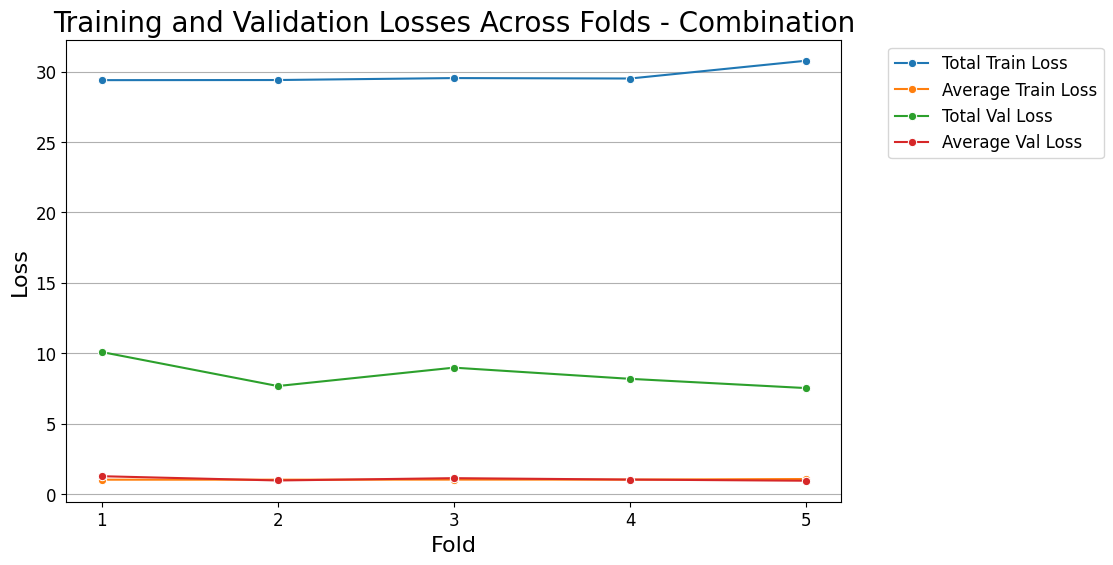

In [49]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='fold', y='total_train_loss', data=folds_loss, marker='o', label='Total Train Loss')
sns.lineplot(x='fold', y='avg_train_loss', data=folds_loss, marker='o', label='Average Train Loss')
sns.lineplot(x='fold', y='total_val_loss', data=folds_loss, marker='o', label='Total Val Loss')
sns.lineplot(x='fold', y='avg_val_loss', data=folds_loss, marker='o', label='Average Val Loss')


plt.title('Training and Validation Losses Across Folds - Combination', fontsize=20)

plt.xlabel('Fold',fontsize=16)
plt.xticks(folds_loss['fold'], fontsize=12)
plt.ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize = 12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Combination_Training_Validation_Losses_Across_Folds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Group the training stats data frame by folds and filter out the validation accuracy column:

In [50]:
folds_acc = df.groupby('fold')['val_accuracy'].mean()
folds_acc = folds_acc.reset_index()

In [51]:
folds_acc

,fold,val_accuracy
0,1,0.68
1,2,0.66
2,3,0.68
3,4,0.68
4,5,0.68


Plot validation accuracy across folds:

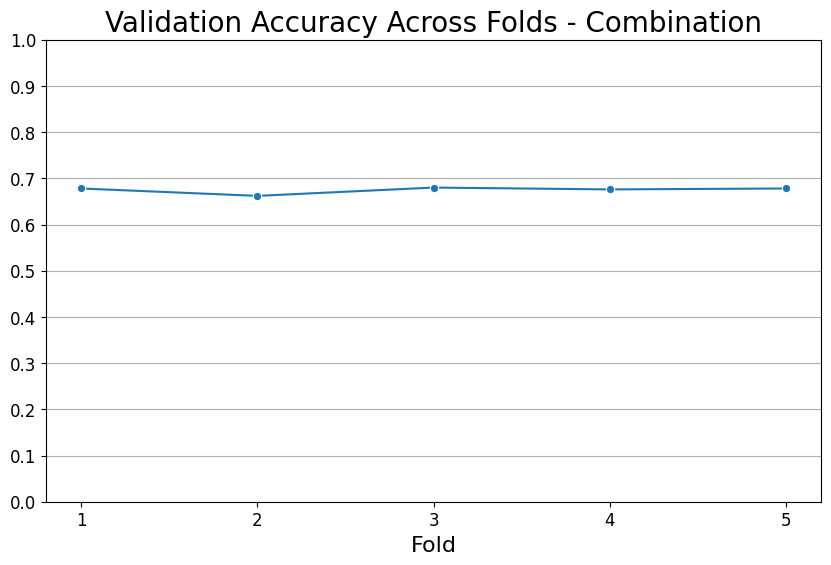

In [52]:
plt.figure(figsize=(10, 6))

sns.lineplot(x='fold', y='val_accuracy', data=folds_acc, marker='o')


plt.title('Validation Accuracy Across Folds - Combination',fontsize=20)

plt.xlabel('Fold', fontsize = 16)
plt.xticks(folds_acc['fold'],fontsize=12)
plt.ylabel('')
plt.yticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1],fontsize=12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Combined_Validation_Accuracy_Across_Folds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Plot f1-macro scores across folds:

In [53]:
folds_f1 = df.groupby('fold')['f1_macro'].mean()
folds_f1 = folds_f1.reset_index()

In [54]:
folds_f1

,fold,f1_macro
0,1,0.36
1,2,0.44
2,3,0.44
3,4,0.46
4,5,0.44


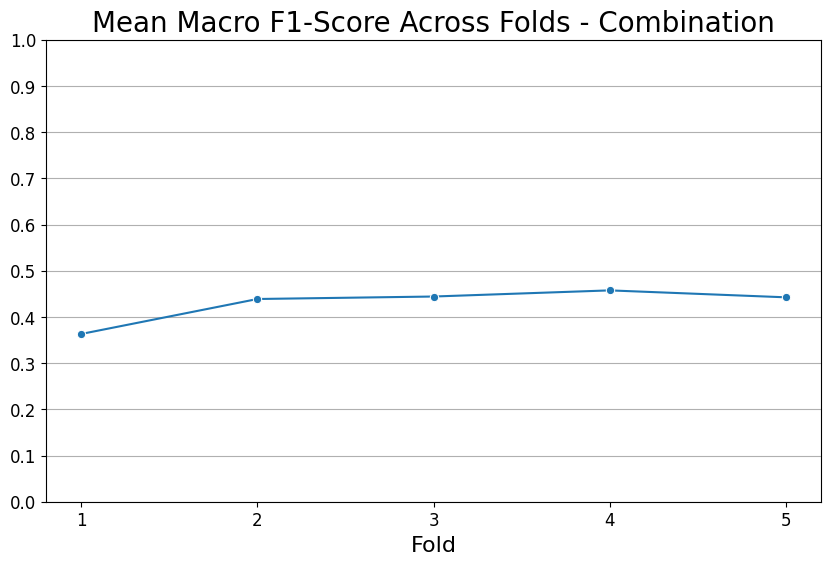

In [55]:
plt.figure(figsize=(10, 6))

sns.lineplot(x='fold', y='f1_macro', data=folds_f1, marker='o')


plt.title('Mean Macro F1-Score Across Folds - Combination',fontsize=20)

plt.xlabel('Fold', fontsize = 16)
plt.xticks(folds_f1['fold'],fontsize=12)
plt.ylabel('')
plt.yticks([0,.10,.20,.30,.40,.50,.60,.70,.80,.90,1],fontsize=12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Combination_Macro_F1_Across_Folds_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

### Compare Epochs of The Best Fold

In [56]:
folds_f1 = df.groupby('fold')['f1_macro'].max()
best = folds_f1.idxmax()
best

5

In [57]:
folds_f1

,f1_macro
fold,
1,0.46
2,0.53
3,0.57
4,0.54
5,0.58


In [58]:
epochs = df[df['fold'] == best].groupby('epoch')[['total_train_loss','avg_train_loss','total_val_loss', 'avg_val_loss']].mean()
epochs = epochs.reset_index()
epochs

,epoch,total_train_loss,avg_train_loss,total_val_loss,avg_val_loss
0,1,52.74,1.82,11.44,1.43
1,2,37.13,1.28,7.82,0.98
2,3,27.52,0.95,6.48,0.81
3,4,20.81,0.72,6.28,0.79
4,5,15.72,0.54,5.58,0.70


Compare epoch losses of the best fold:

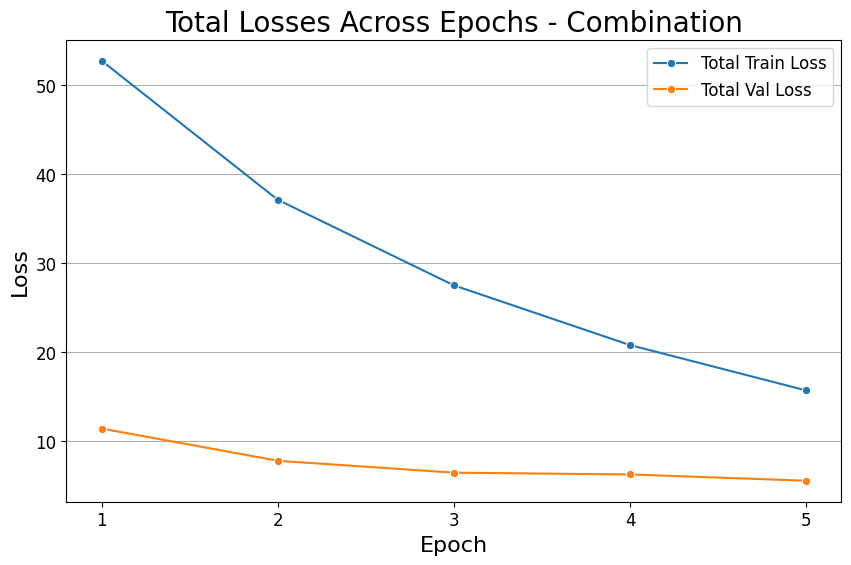

In [59]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='total_train_loss', data=epochs, marker='o', label='Total Train Loss')
sns.lineplot(x='epoch', y='total_val_loss', data=epochs, marker='o', label='Total Val Loss')

plt.title('Total Losses Across Epochs - Combination', fontsize=20)

plt.xlabel('Epoch',fontsize=16)
plt.xticks(epochs['epoch'],fontsize=12)
plt.ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)

plt.legend(loc='upper right',fontsize = 12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Combined_Total_Losses_Across_Epochs_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

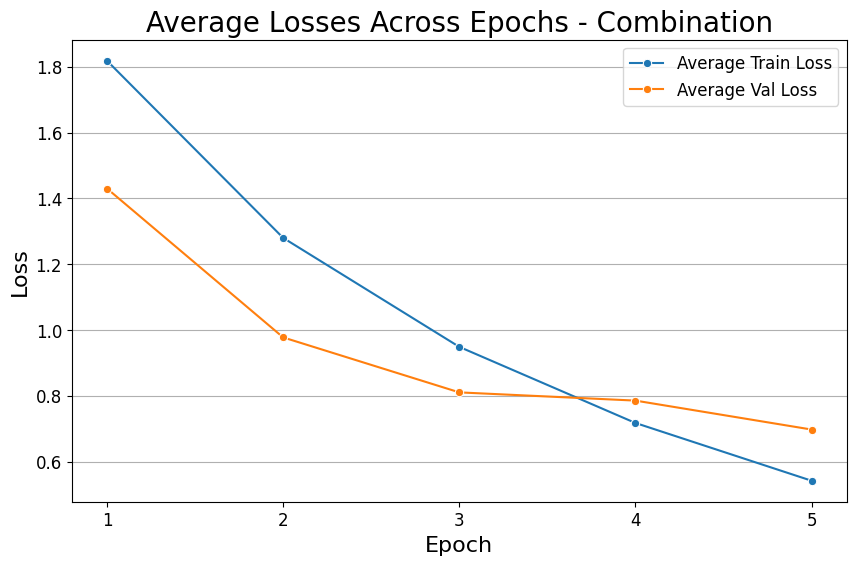

In [60]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='avg_train_loss', data=epochs, marker='o', label='Average Train Loss')
sns.lineplot(x='epoch', y='avg_val_loss', data=epochs, marker='o', label='Average Val Loss')


plt.title('Average Losses Across Epochs - Combination', fontsize=20)

plt.xlabel('Epoch',fontsize=16)
plt.xticks(epochs['epoch'],fontsize=12)
plt.ylabel('Loss',fontsize=16)
plt.yticks(fontsize=12)

plt.legend(loc='upper right',fontsize = 12)
plt.grid(axis='y')

plt.savefig(FOLDER_PATH+'Combined_Average_Losses_Across_Epochs_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

### Evaluate the Best Fold on Test Set

Here, we evaluate the trained model of the best fold, using the same method used to evaluate the pre-trained model. \
We do this to see if there was significant improvement after being trained with the curated dataset.

In [61]:
best_fold_path = 'fold_' + str(best) + '.bin'
best_fold_path

'fold_5.bin'

In [62]:
# Load best model:
if os.path.exists(best_fold_path):
    model.load_state_dict(torch.load(best_fold_path))

else:
  print(f"Error: {best_fold_path} does not exist")

####Test Batches

In [63]:
model.eval()
torch.set_grad_enabled(False)

for i, test_batch in enumerate(test_dataloader):
  test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
  print(test_status, end='\r')

  b_input_ids = test_batch[0].to(device)
  b_input_mask = test_batch[1].to(device)
  b_token_type_ids = test_batch[2].to(device)


  outputs = model(b_input_ids,
                  token_type_ids=None,
                  attention_mask=b_input_mask,
                  return_dict = False)

  preds = outputs[0]
  test_preds = preds.detach().cpu().numpy()


  if i == 0:  # first batch
    stacked_test_preds = test_preds

  else:
    stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


# Round predictions to either 0 or 1
final_preds = np.argmax(stacked_test_preds, axis=1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


####Performance Scores

Like before, we can calculate the model's performance scores using the function that was previously defined. \

In [64]:
labels = df_test['CLASS']

report, accuracy = classification_report_with_accuracy_score(final_preds, labels)
# report is a DataFrame
print(report)

              precision  recall  f1-score  support
0                  0.33    0.18      0.23    17.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.73    0.91      0.81   108.00
4                  0.83    0.82      0.82    71.00
5                  0.00    0.00      0.00     6.00
6                  0.74    0.70      0.72    53.00
7                  0.67    0.75      0.71    16.00
8                  0.00    0.00      0.00     8.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.37    0.37      0.37   282.00
weighted avg       0.69    0.74      0.71   282.00


Get the missclassified tweets:

In [65]:
posts = df_test[POST]
ids = df_test[POST_ID]
stances = df_test[STANCE]
sentiments = df_test[SENTIMENT]

In [66]:
posts[:5]

,content
0,Vamos preparar POA para receber a vacina contr...
1,"Enquanto isso, a Pfizer desistiu de pedir lice..."
2,"Do total, R$ 1,3 bilhão corresponderá à encome..."
3,Idosos com Covid-19 foram isolados em uma sala...
4,FDA libera vacina da Moderna nos USA enquanto ...


In [67]:
print(df_test.head())

  tweet_id                                            content  \
0     A743  Vamos preparar POA para receber a vacina contr...   
1     A599  Enquanto isso, a Pfizer desistiu de pedir lice...   
2     A930  Do total, R$ 1,3 bilhão corresponderá à encome...   
3     A589  Idosos com Covid-19 foram isolados em uma sala...   
4     A779  FDA libera vacina da Moderna nos USA enquanto ...   

  Corrected_sentimento Corrected_stance Corrected_relevante  \
0             positive        favorable            relevant   
1             negative        favorable            relevant   
2             positive        favorable            relevant   
3             negative        favorable            relevant   
4             negative          unclear            relevant   

  Corrected_children  round   date_post  year  CLASS DATASET  
0              false     27  2020-10-18  2020      4    Test  
1              false     11  2020-12-29  2020      3    Test  
2              false      6  2020-12-02  

In [68]:
ids[:5]

,tweet_id
0,A743
1,A599
2,A930
3,A589
4,A779


In [69]:
wrong_preds = []

for i in range(len(labels)):
  predicted = final_preds[i]
  correct = labels[i]

  if predicted != correct:
    info = {'post id': ids[i],
            'post content': posts[i],
            'prediction': predicted,
            'correct label': correct,
            'stance': stances[i],
            'sentiment': sentiments[i]}
    wrong_preds.append(info)

In [70]:
df = pd.DataFrame(wrong_preds)
df

,post id,post content,prediction,correct label,stance,sentiment
0,A779,FDA libera vacina da Moderna nos USA enquanto ...,3,6,unclear,negative
1,A834,#Repost @CarlaZambelli38 \n\nATENÇÃO! Entrevis...,4,8,unclear,unclear
2,A694,Quem aí já assistiu ao novo episódio de Dias M...,3,8,unclear,unclear
3,B3666,@HaddadDebochado Faz menos mal do que acredita...,6,8,unclear,unclear
4,A626,@kellymatos Alguém tem dúvida que o abre e fec...,3,0,unfavorable,negative
...,...,...,...,...,...,...
69,A265,E o gov do Paraná segue o mesmo ritmo. Chegara...,3,6,unclear,negative
70,B1361,@gui_pinheiro A Cloroquina do Adeus,7,6,unclear,negative
71,A1021,‘MP da vacina’ acirra o conflito federativo ht...,3,6,unclear,negative
72,A1941,SAÚDE - Deputado Elias Vaz cobra informações s...,6,3,favorable,negative


In [ ]:
# classes = {0:'unfav/neg',
#            1:'unfav/pos',
#            2:'unfav/unclear',
#            3:'fav/neg',
#            4:'fav/pos',
#            5:'fav/unclear',
#            6:'unclear/neg',
#            7:'unclear/pos',
#            8:'unclear/unclear'}

def revert_condition(x):
    if x == 0:
        return (NEGATIVE_STANCE + '/' + NEGATIVE_SENTIMENT)
    elif x == 1:
        return (NEGATIVE_STANCE + '/' + POSITIVE_SENTIMENT)

    elif x == 2:
        return (NEGATIVE_STANCE + '/unclear')

    elif x == 3:
        return (POSITIVE_STANCE + '/' + NEGATIVE_SENTIMENT)

    elif x == 4:
        return (POSITIVE_STANCE + '/' + POSITIVE_SENTIMENT)

    elif x == 5:
        return (POSITIVE_STANCE + '/unclear')

    elif x == 6:
        return ('unclear/' + NEGATIVE_SENTIMENT)

    elif x == 7:
        return ('unclear/' + POSITIVE_SENTIMENT)

    else: # x == 8
        return ('unclear/unclear')


df['prediction'] = df['prediction'].apply(condition)
df['correct label'] = df['correct label'].apply(condition)

In [71]:
path = FOLDER_PATH + 'wrong_predictions_seed'+ str(SEED_VAL) + '.cvs'
df.to_csv(path)

path = FOLDER_PATH + 'wrong_predictions_seed'+ str(SEED_VAL) + '.xlsx'
df.to_excel(path)

Plot report as a table and save figure as a png:

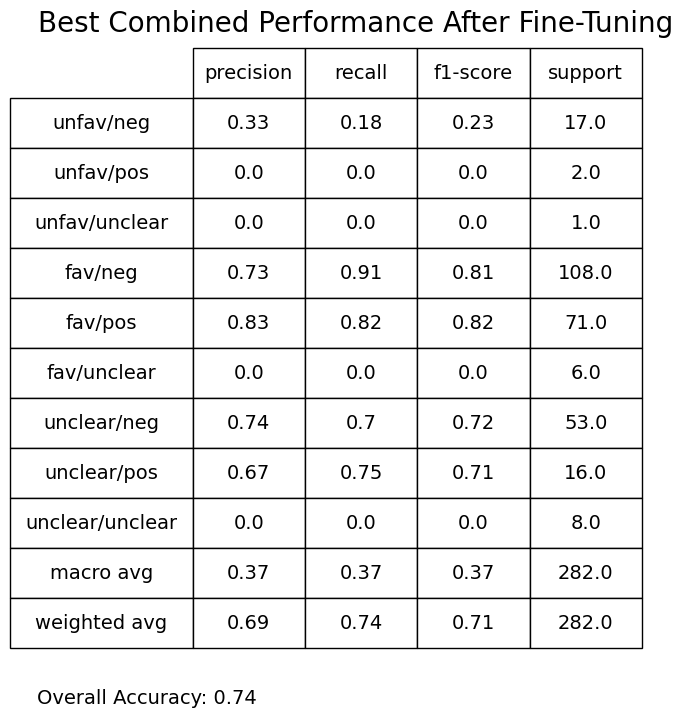

In [74]:
without_acc = report.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', 'macro avg', 'weighted avg']]
without_acc = without_acc.rename(index={'0': classes[0],
                                        '1': classes[1],
                                        '2': classes[2],
                                        '3': classes[3],
                                        '4': classes[4],
                                        '5': classes[5],
                                        '6': classes[6],
                                        '7': classes[7],
                                        '8': classes[8],})

fig, ax = plt.subplots(figsize=(2,8))
ax.axis('off')
table = pd.plotting.table(ax, without_acc, loc='right',cellLoc='center',rowLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.9, 3)
plt.title('Best Combined Performance After Fine-Tuning',
           loc='left',fontsize=20)
acc_str = 'Overall Accuracy: '+ str(accuracy.round(decimals=2))
fig.text(0.67, 0.05, acc_str, ha='center', fontsize=14)

plt.savefig(FOLDER_PATH+'BestCombinedPerformanceTable_TrainedModel_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)

Plot the confusion matrix to visualize the model's predictions against their true value, and save the figure as a png:

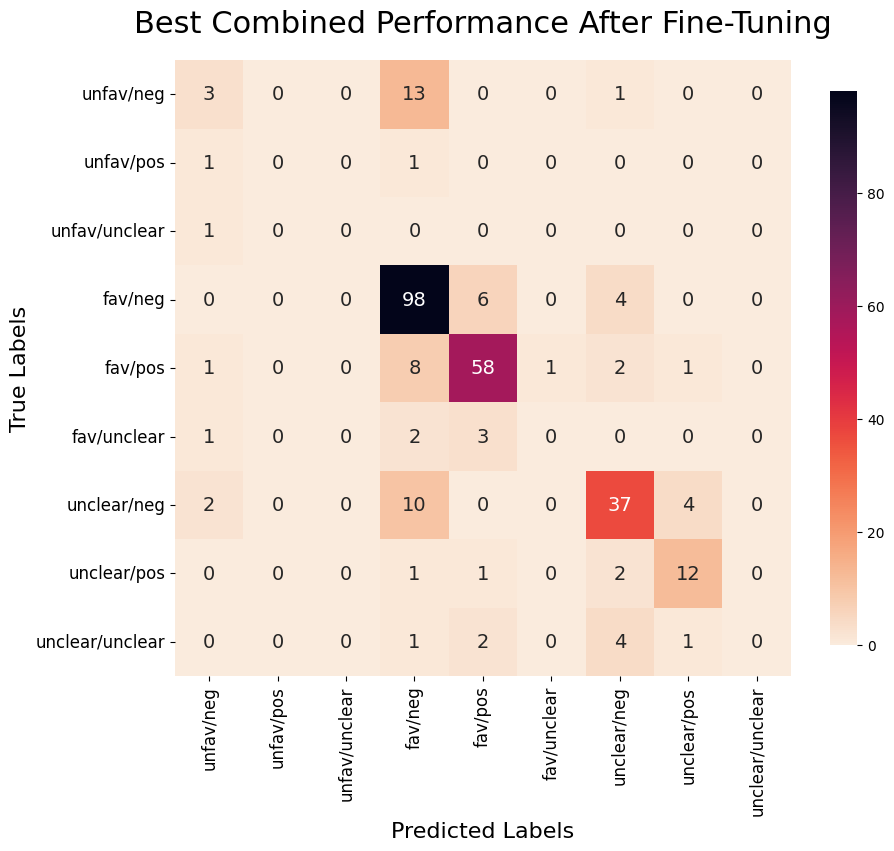

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


matrix = confusion_matrix(df_test['CLASS'], final_preds)
fig = plt.figure(figsize=(10, 8))
ax = sns.heatmap(matrix, annot=True,cmap="rocket_r", fmt = '.0f',
            yticklabels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]],
            xticklabels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]],square=True,
                 annot_kws={"size": 14},cbar=True,
                 cbar_kws={'shrink': 0.9})

plt.xticks(fontsize=12)  # X-axis tick labels font size
plt.yticks(fontsize=12)

# Add title and labels
plt.title('Best Combined Performance After Fine-Tuning', fontsize=22, loc='center',
          pad=20)
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)

plt.savefig(FOLDER_PATH+'BestCombinedConfusionMatrix_TrainedModel_Seed'+ str(SEED_VAL) + '.png', format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)


## Evaluate All Folds on Test Set

In [76]:
folds = []
for i in range(NUM_FOLDS):
  model_name = 'fold_' + str(i+1) + '.bin'
  folds.append(model_name)

In [78]:
def plot_table(fold_n, report, accuracy, filename):

  without_acc = report.loc[['0', '1', '2', '3', '4', '5', '6', '7', '8', 'macro avg', 'weighted avg']]
  without_acc = without_acc.rename(index={'0': classes[0],
                                          '1': classes[1],
                                          '2': classes[2],
                                          '3': classes[3],
                                          '4': classes[4],
                                          '5': classes[5],
                                          '6': classes[6],
                                          '7': classes[7],
                                          '8': classes[8]})

  fig, ax = plt.subplots(figsize=(2,8))
  ax.axis('off')
  table = pd.plotting.table(ax, without_acc, loc='right',cellLoc='center',rowLoc='center')
  table.auto_set_font_size(False)
  table.set_fontsize(14)
  table.scale(3, 3)
  plt.title(('Combined Performance After Fine-Tuning: Fold ' + str(fold_n)),
            loc='left',fontsize=20)
  acc_str = 'Overall Accuracy: '+ str(accuracy.round(decimals=2))
  fig.text(0.67, 0.05, acc_str, ha='center', fontsize=14)

  plt.savefig(filename, format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)


def plot_matrix(fold_n, matrix, filename):
  fig = plt.figure(figsize=(10, 8))
  ax = sns.heatmap(matrix, annot=True,cmap="rocket_r", fmt = '.0f',
              yticklabels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]],
              xticklabels=[classes[0], classes[1], classes[2], classes[3], classes[4], classes[5], classes[6], classes[7], classes[8]],square=True,
                  annot_kws={"size": 14},cbar=True,
                  cbar_kws={'shrink': 0.9})

  plt.xticks(fontsize=12)  # X-axis tick labels font size
  plt.yticks(fontsize=12)

  # Add title and labels
  plt.title(('Combined Performance After Fine-Tuning: Fold ' + str(fold_n)), fontsize=22, loc='center',
            pad=20)
  plt.xlabel('Predicted Labels', fontsize=16)
  plt.ylabel('True Labels', fontsize=16)

  plt.savefig(filename, format='png', transparent = True, bbox_inches='tight',pad_inches=0.1)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fold1:
               precision  recall  f1-score  support
0                  0.64    0.41      0.50    17.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.77    0.83      0.80   108.00
4                  0.74    0.92      0.82    71.00
5                  0.00    0.00      0.00     6.00
6                  0.80    0.74      0.76    53.00
7                  0.71    0.75      0.73    16.00
8                  0.00    0.00      0.00     8.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.41    0.41      0.40   282.00
weighted avg       0.71    0.76      0.73   282.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fold2:
               precision  recall  f1-score  support
0                  0.50    0.18      0.26    17.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.73    0.93      0.82   108.00
4                  0.79    0.86      0.82    71.00
5                  0.00    0.00      0.00     6.00
6                  0.82    0.75      0.78    53.00
7                  0.92    0.75      0.83    16.00
8                  0.00    0.00      0.00     8.00
accuracy           0.77    0.77      0.77     0.77
macro avg          0.42    0.39      0.39   282.00
weighted avg       0.71    0.77      0.73   282.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fold3:
               precision  recall  f1-score  support
0                  0.42    0.29      0.34    17.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.72    0.93      0.81   108.00
4                  0.81    0.79      0.80    71.00
5                  0.00    0.00      0.00     6.00
6                  0.82    0.75      0.78    53.00
7                  0.86    0.75      0.80    16.00
8                  0.00    0.00      0.00     8.00
accuracy           0.76    0.76      0.76     0.76
macro avg          0.40    0.39      0.39   282.00
weighted avg       0.71    0.76      0.73   282.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fold4:
               precision  recall  f1-score  support
0                  0.53    0.53      0.53    17.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.83    0.76      0.79   108.00
4                  0.67    0.94      0.78    71.00
5                  0.00    0.00      0.00     6.00
6                  0.84    0.70      0.76    53.00
7                  0.59    0.81      0.68    16.00
8                  0.00    0.00      0.00     8.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.38    0.42      0.39   282.00
weighted avg       0.71    0.74      0.71   282.00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Fold5:
               precision  recall  f1-score  support
0                  0.33    0.18      0.23    17.00
1                  0.00    0.00      0.00     2.00
2                  0.00    0.00      0.00     1.00
3                  0.73    0.91      0.81   108.00
4                  0.83    0.82      0.82    71.00
5                  0.00    0.00      0.00     6.00
6                  0.74    0.70      0.72    53.00
7                  0.67    0.75      0.71    16.00
8                  0.00    0.00      0.00     8.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.37    0.37      0.37   282.00
weighted avg       0.69    0.74      0.71   282.00


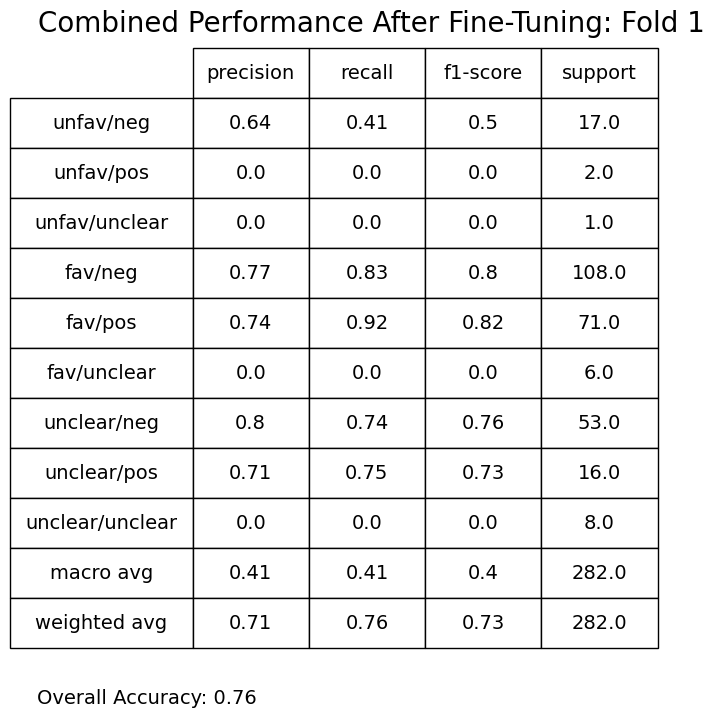

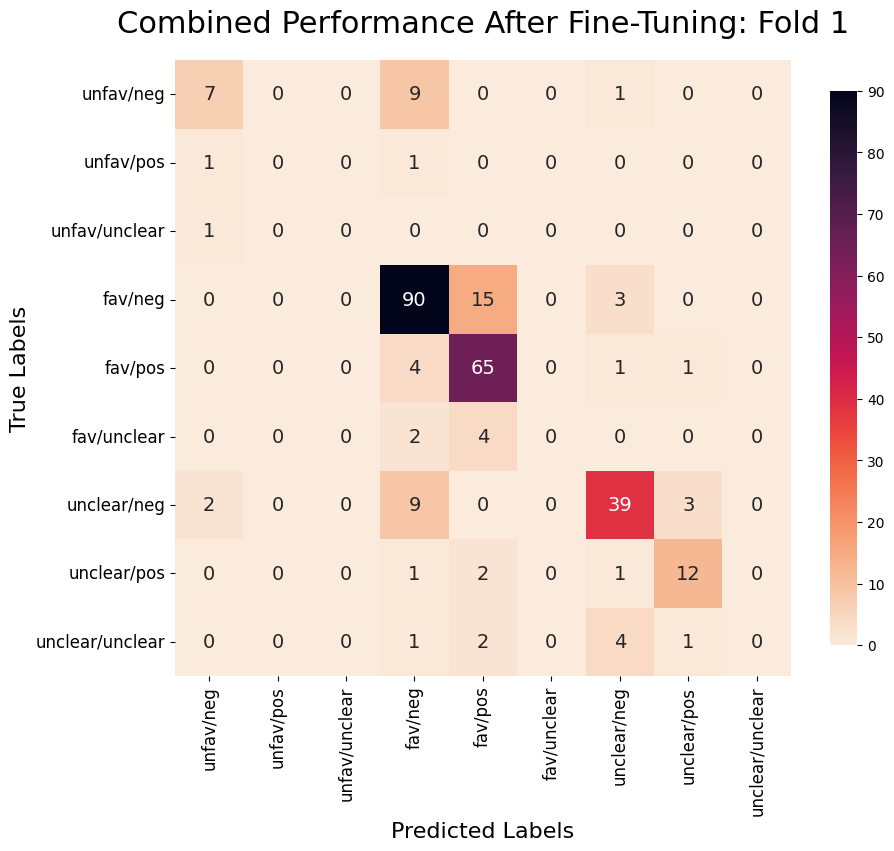

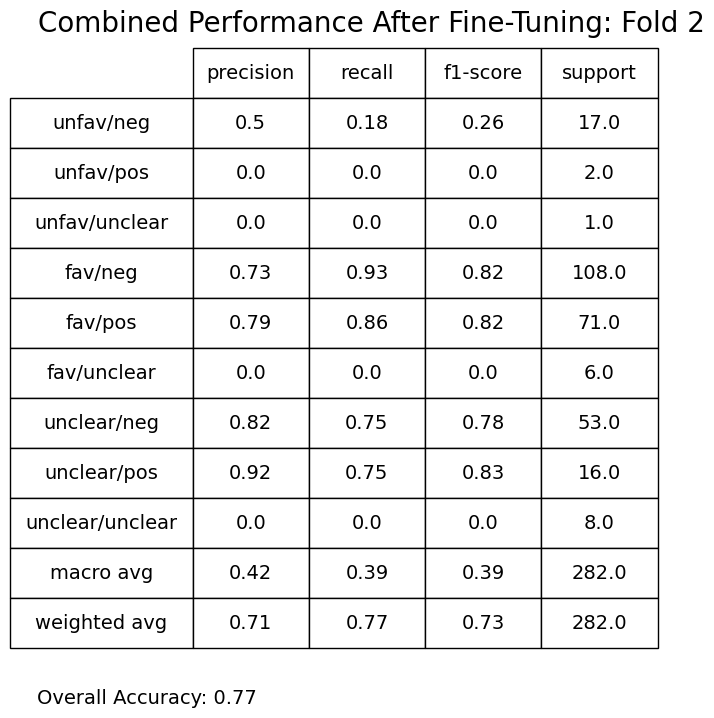

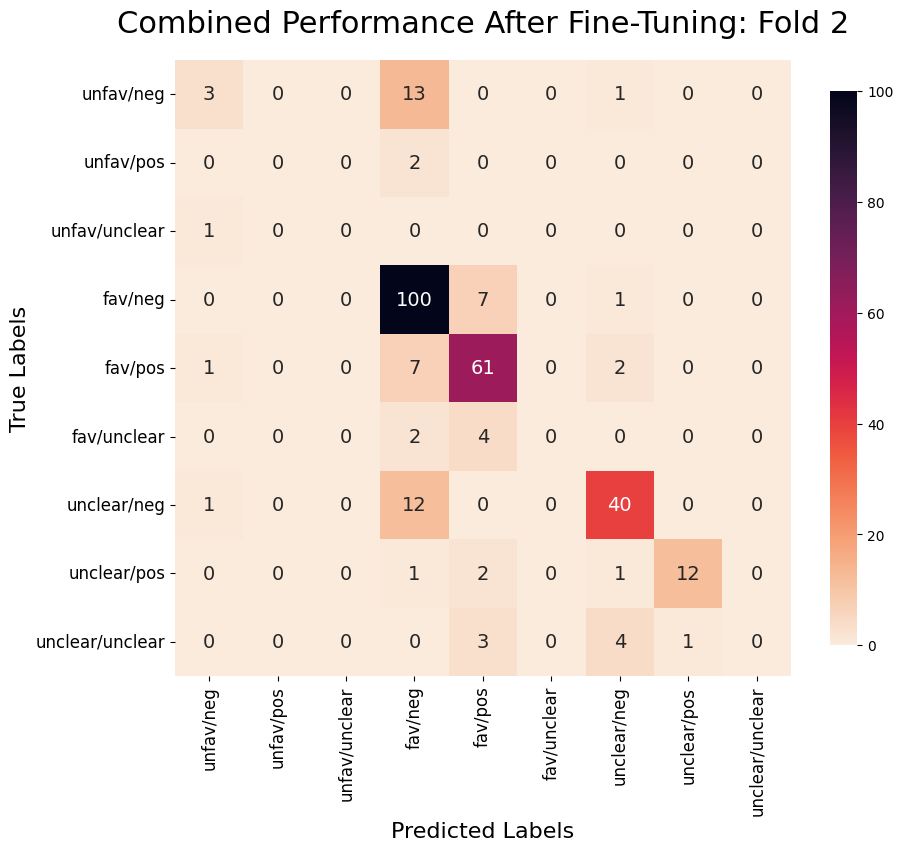

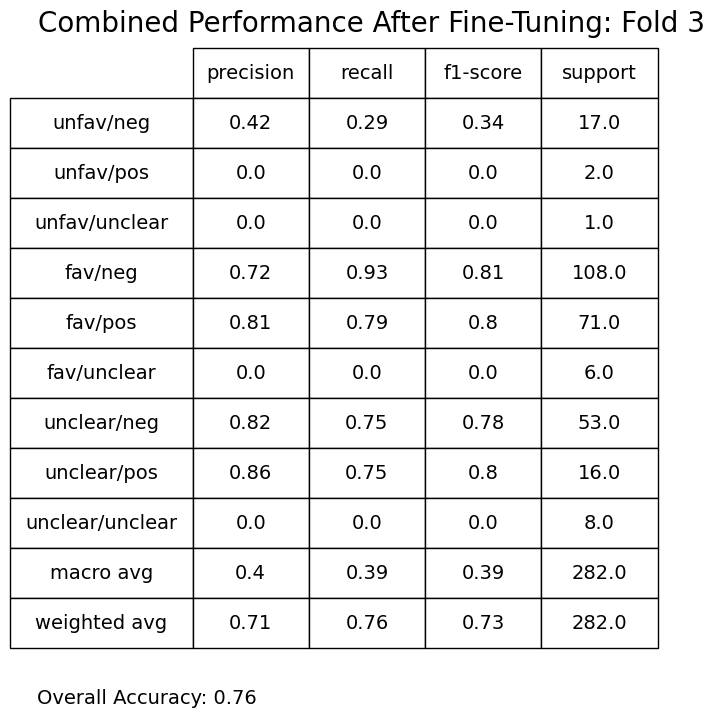

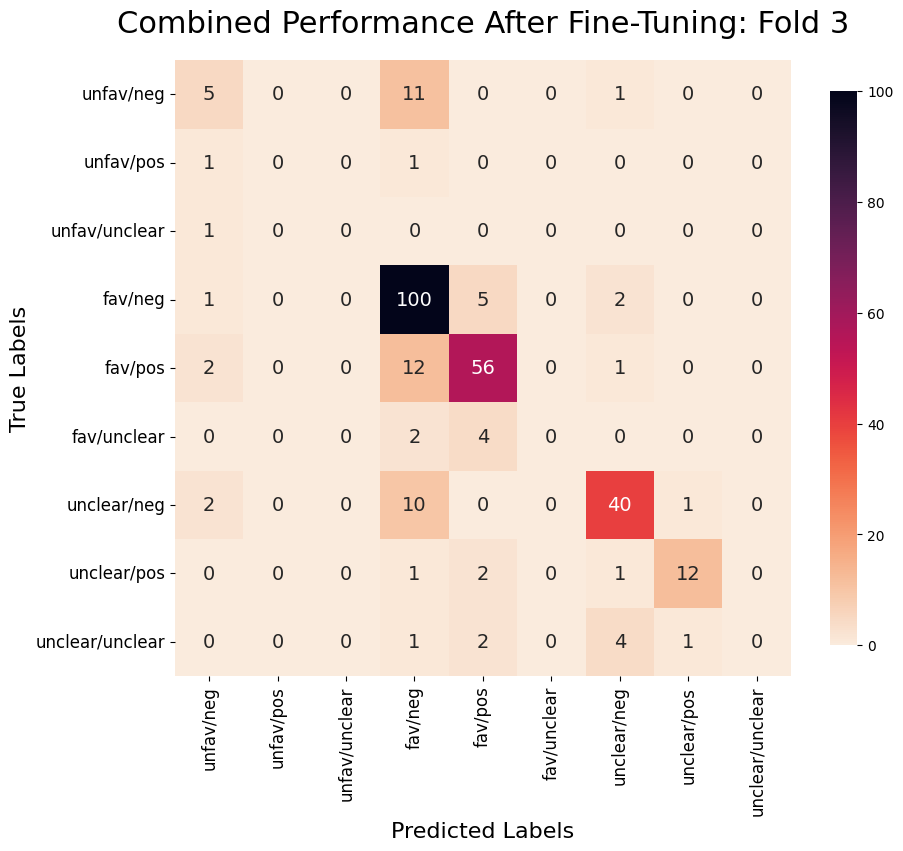

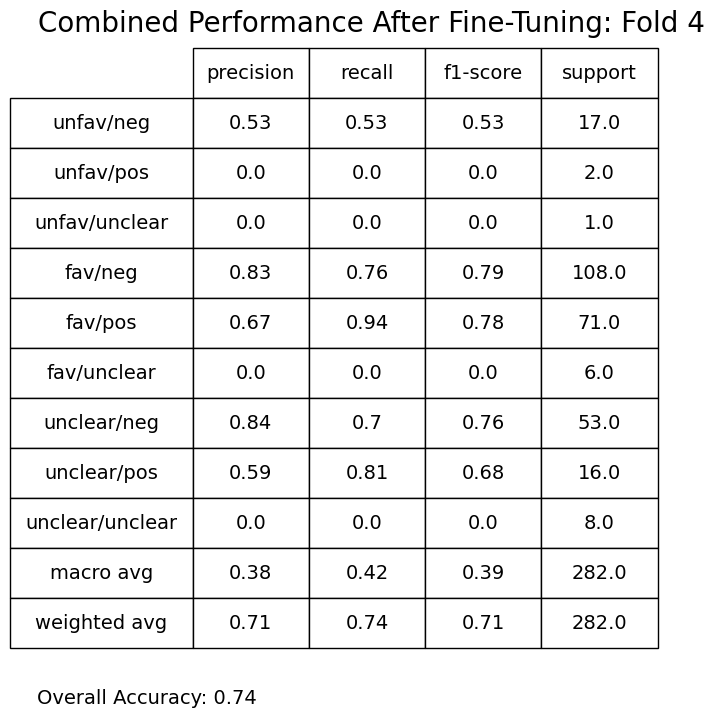

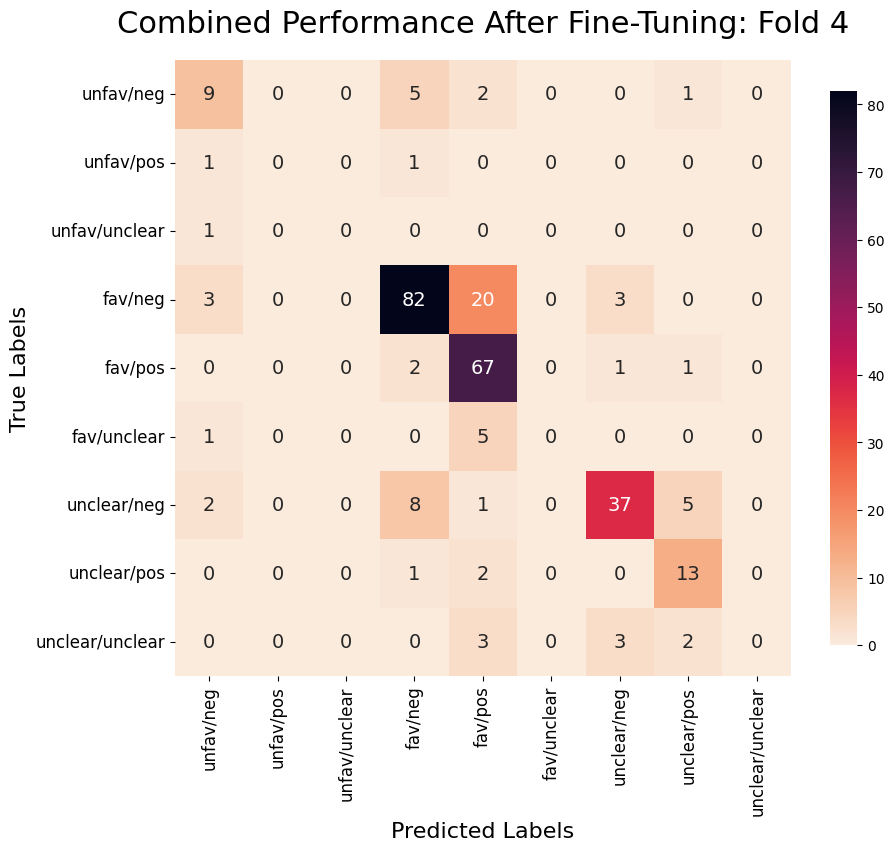

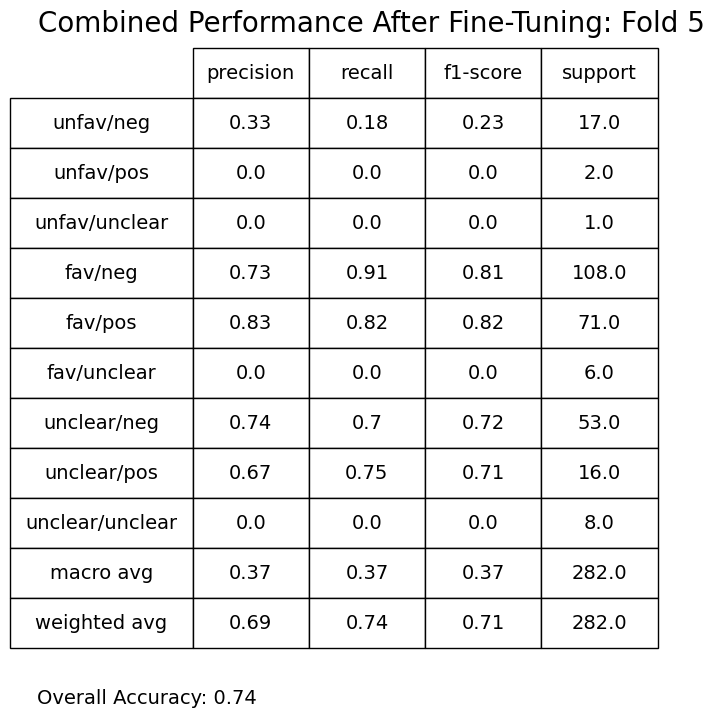

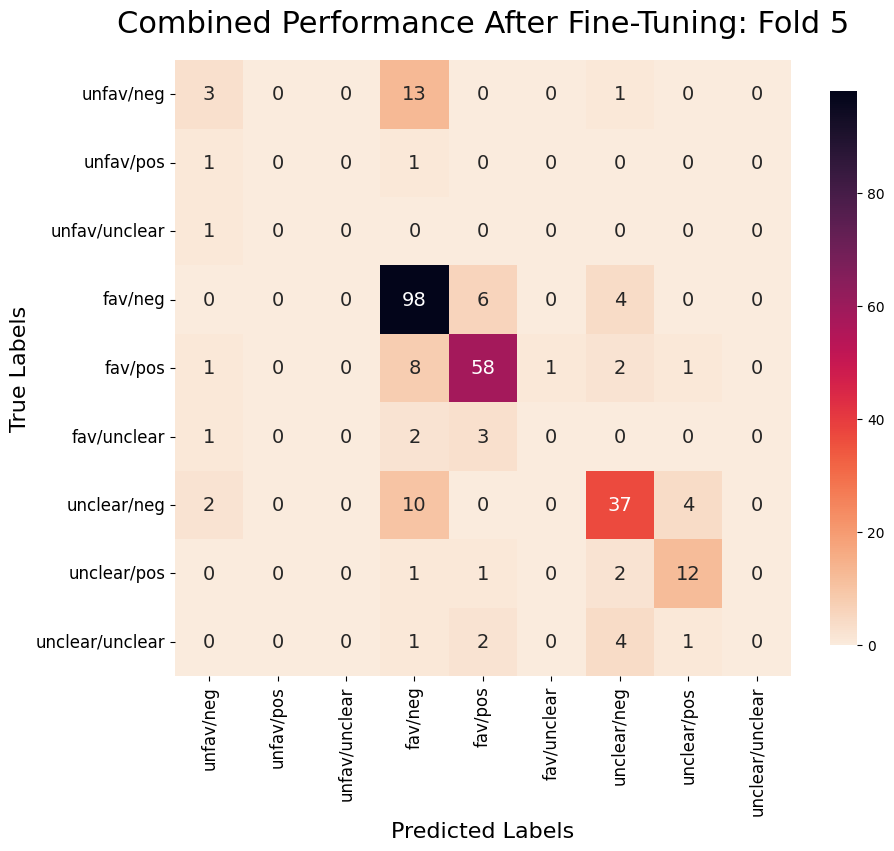

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

fold_n = 1

for model_path in folds:
    # LOAD MODEL #
    if os.path.exists(model_path):
      model.load_state_dict(torch.load(model_path))

    else:
      print(f"Error: {model_path} does not exist")

    # TEST #
    model.eval()
    torch.set_grad_enabled(False)

    for i, test_batch in enumerate(test_dataloader):
      test_status = 'Batch ' + str(i+1) + ' / ' + str(len(test_dataloader))
      print(test_status, end='\r')

      b_input_ids = test_batch[0].to(device)
      b_input_mask = test_batch[1].to(device)
      b_token_type_ids = test_batch[2].to(device)


      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict = False)

      preds = outputs[0]
      test_preds = preds.detach().cpu().numpy()


      if i == 0:  # first batch
        stacked_test_preds = test_preds

      else:
        stacked_test_preds = np.vstack((stacked_test_preds, test_preds))


    # Round predictions to either 0 or 1
    final_preds = np.argmax(stacked_test_preds, axis=1)

    labels = df_test['CLASS']

    report, accuracy = classification_report_with_accuracy_score(final_preds, labels)
    # report is a DataFrame
    print('Fold' + str(fold_n) + ':\n', report)


    table_path = FOLDER_PATH+'Fold ' + str(fold_n) + '_CombinedPerformanceTable_TrainedModel_Seed'+ str(SEED_VAL) + '.png'
    plot_table(fold_n, report, accuracy, table_path)


    matrix = confusion_matrix(labels, final_preds)

    matrix_path = FOLDER_PATH + 'Fold ' + str(fold_n) + '_CombinedConfusionMatrix_TrainedModel_Seed'+ str(SEED_VAL) + '.png'
    plot_matrix(fold_n, matrix, matrix_path)

    fold_n += 1